In [47]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import ultraplot as plot 
import seaborn as sns
import colorcet as cc

import uproot
import mplhep as hep
import hist
import hist.intervals
import hist.plot
import uncertainties

plot.rc['figure.facecolor'] = 'none'
plot.rc['savefig.facecolor'] = 'none'
plot.rc['legend.frameon'] = False
plot.rc['axes.autolimit_mode'] = 'data'
plot.rc['label.size'] = 11
plot.rc['font.size'] = 11


In [48]:

loader_formatted = {
    'nominal': 'Nominal reconstruction',
    'cheated_2d': 'Injected clustering',
    'cheated_vtx': 'Injected vertex',
    'cheated_vtxSelection': 'Injected vertex selection',
    'cheated_3d': 'Injected 3D matching',
    'cheated_nuH': r'Injected $\nu$-hierarchy',
    'cheated_mva': 'Injected track-score',
    'cheated_2d_vtx': 'Injected clustering + vertex',
    'cheated_2d_vtx_3d': 'Injected clustering + vertex + 3D matching',
    'cheated_2d_vtx_3d_nu': r'Injected clustering + vertex + 3D matching + $\nu$-hierarchy',
    'cheated_2d_vtx_3d_nu_mva': r'Injected clustering + vertex + 3D matching + $\nu$-hierarchy + track-score'
}


In [49]:
def plot_map(loader):
    data = uproot.open('CCNp_study.root:Np')
    df = data[loader].arrays(library='pd')
    df = df[df['reco_Np'] > 0]  # all Np > 5 → 6
    df = df[df['true_Np_reco_mu'] > 0]
    df = pd.crosstab(df['reco_Np'], df['true_Np_reco_mu'])
    # df = df.drop(columns=[0])

    df_norm = df.div(df.sum(axis=0), axis=1)
    df_norm = df_norm.replace(0, np.nan)
    
    fig, ax = plot.subplots(width=7, height=2, ltitle=loader_formatted[loader])
    ax.heatmap(df_norm, 
               robust=True, cmap=cc.CET_L20,
               # norm=mpl.colors.LogNorm(1e-1, 1e3), 
               # norm=mpl.colors.LogNorm(1e-1, 5e3), 
               norm=mpl.colors.PowerNorm(0.25, 1e-4, 2),
               labels=True, fmt='sci', precision=1,
               labels_kw={'weight': 'bold'}, colorbar=False, aspect='auto'
    )
    
    ax.format(grid=False, tickminor=False, xlabel='True Np', ylabel='Reco. Np', xformatter='formatstr', xformatter_kw={'fmt': '%d'})

    fig.savefig(f'plots_CCNp_test/Np_comparison_{loader}.pdf', bbox_inches='tight')


(None, None, None)

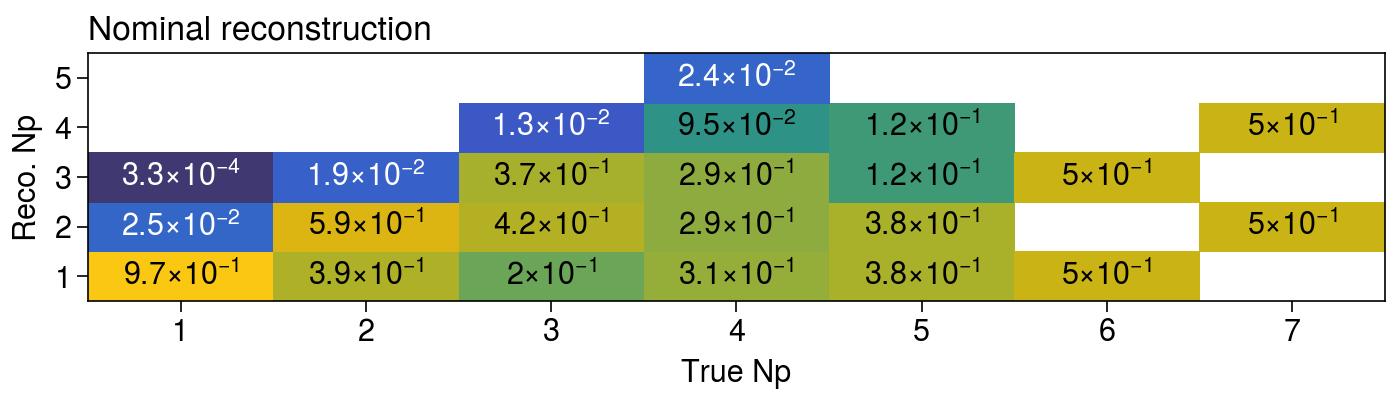

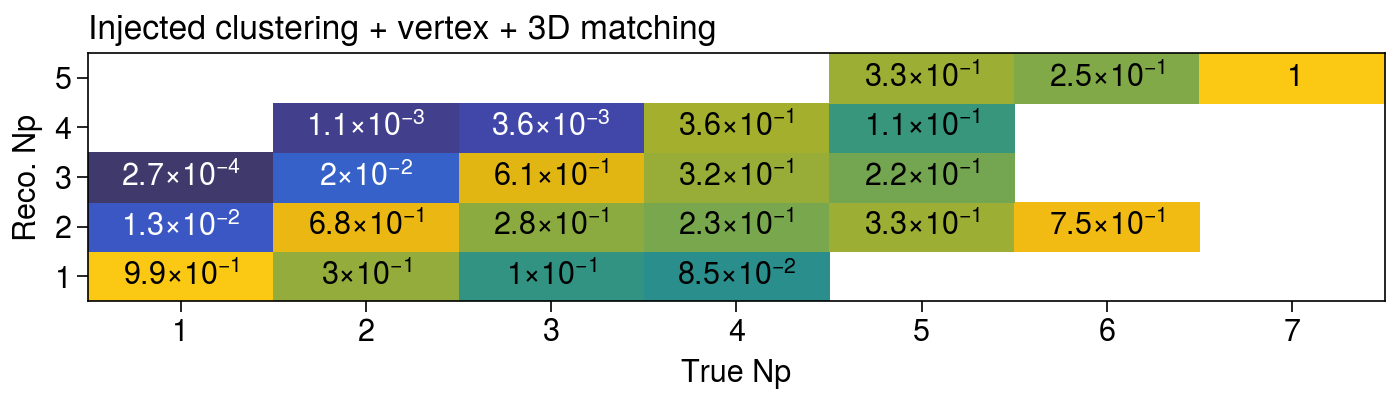

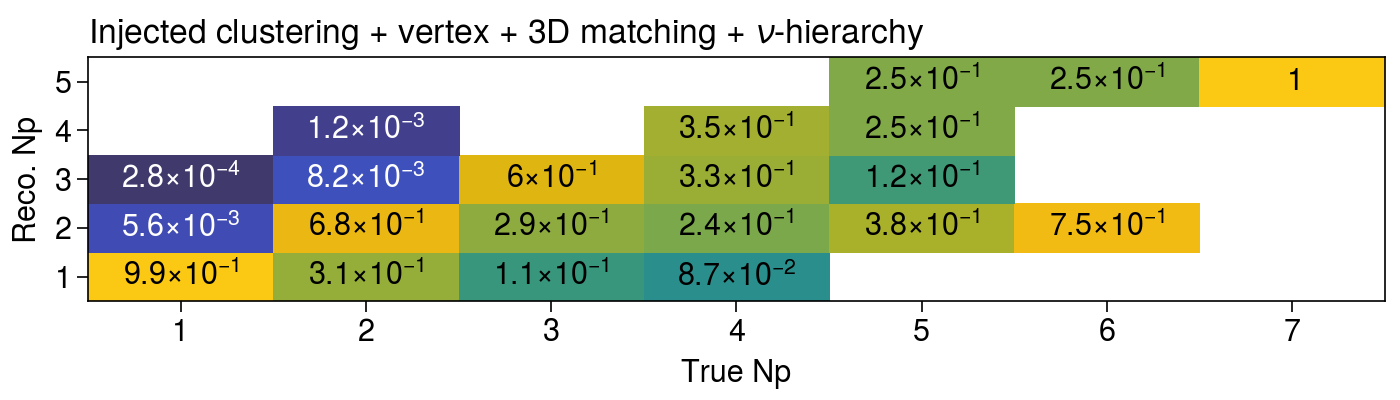

In [50]:
# for loader in loader_formatted:
plot_map('nominal'), plot_map('cheated_2d_vtx_3d'), plot_map('cheated_2d_vtx_3d_nu')

In [51]:
class MidpointNormalize(mpl.colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


def plot_map(loader):
    data = uproot.open('CCNp_study.root:Np')
    df = data[loader].arrays(library='pd')
    df['reco_Np'] = df['reco_Np'].clip(upper=3)   # all Np > 5 → 6
    df['true_Np_reco_mu'] = df['true_Np_reco_mu'].clip(upper=6)
    df = pd.crosstab(df['reco_Np'], df['true_Np_reco_mu']).to_numpy()

    df_nom = data['nominal'].arrays(library='pd')
    df_nom['reco_Np'] = df_nom['reco_Np'].clip(upper=3)
    df_nom['true_Np_reco_mu'] = df_nom['true_Np_reco_mu'].clip(upper=6)
    df_nom = pd.crosstab(df_nom['reco_Np'], df_nom['true_Np_reco_mu']).to_numpy()

    df = df/df_nom
    
    fig, ax = plot.subplots(width=7, height=2, ltitle=loader_formatted[loader])
    ax.heatmap(df, 
               robust=True, cmap=cc.CET_D1A, 
               norm=MidpointNormalize(midpoint=1),
               labels=True, precision=3,
               labels_kw={'weight': 'bold'}, colorbar=True, aspect='auto'
    )
    
    ax.format(grid=False, tickminor=False, xlabel='True Np', ylabel='Reco. Np', xformatter='formatstr', xformatter_kw={'fmt': '%d'})

    fig.savefig(f'plots_CCNp_test/Np_comparison_ratio_{loader}.pdf', bbox_inches='tight')

/var/folders/rz/xbjc5djs43l2yfd7lq67www80000gn/T/ipykernel_97444/1473108290.py:30: RuntimeWarning: invalid value encountered in divide
  df = df/df_nom


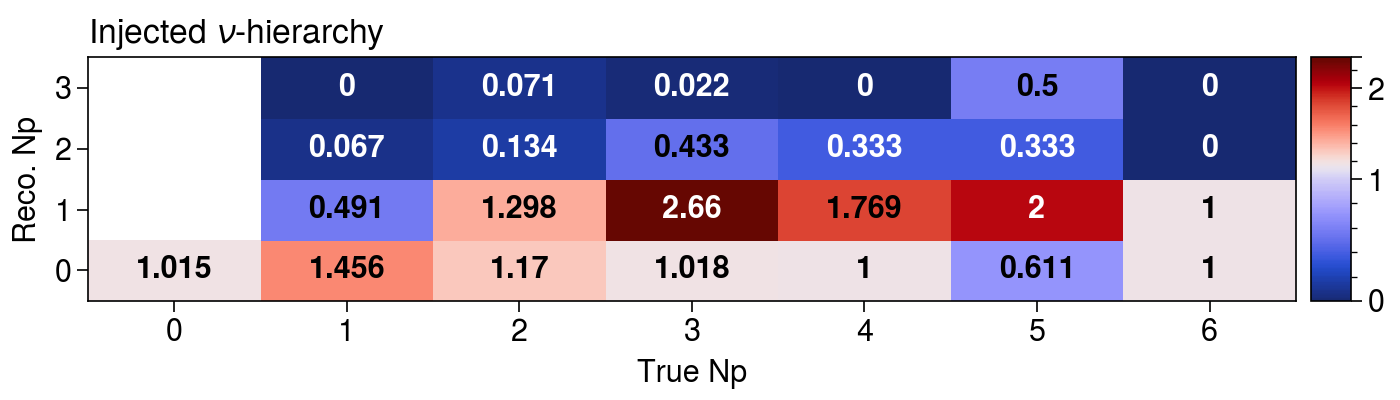

In [52]:
# for loader in loader_formatted:
plot_map('cheated_nuH')

In [53]:
data = uproot.open('CCNp_study_MC.root:Np')


df_nom = data['nominal'].arrays(library='pd')
df_nom = pd.crosstab(df_nom['reco_Np'], df_nom['true_Np'])

In [54]:
class Analysis:
    def __init__(self, data, binning, tree_bases=['reco_true_{}', 'reco_{}', 'true_{}']):
        self.binning = binning
        self.data = data

        self.reco_true_base_string, self.reco_base_string, self.true_base_string = tree_bases

    def efficiency(self, tree_name: str, variable: str = 'true_E'):

        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, true.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        true_values = true_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            efficiency = reco_true_values/true_values
            efficiency_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, true_values, 'efficiency'
            )
        
        return efficiency, efficiency_uncertainty
    
    def purity(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)

        reco_true_values = reco_true_H.values()
        reco_values = reco_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            purity = reco_true_values/reco_values
            purity_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, reco_values, 'efficiency'
            )
        
        return purity, purity_uncertainty

    def spectra(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.event, reco.event, on='event')
        common = pd.merge(common.event, true.event, on='event')

        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.event.isin(common.event)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.event.isin(common.event)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.event.isin(common.event)][variable].values)

        return reco_true_H, reco_H, true_H



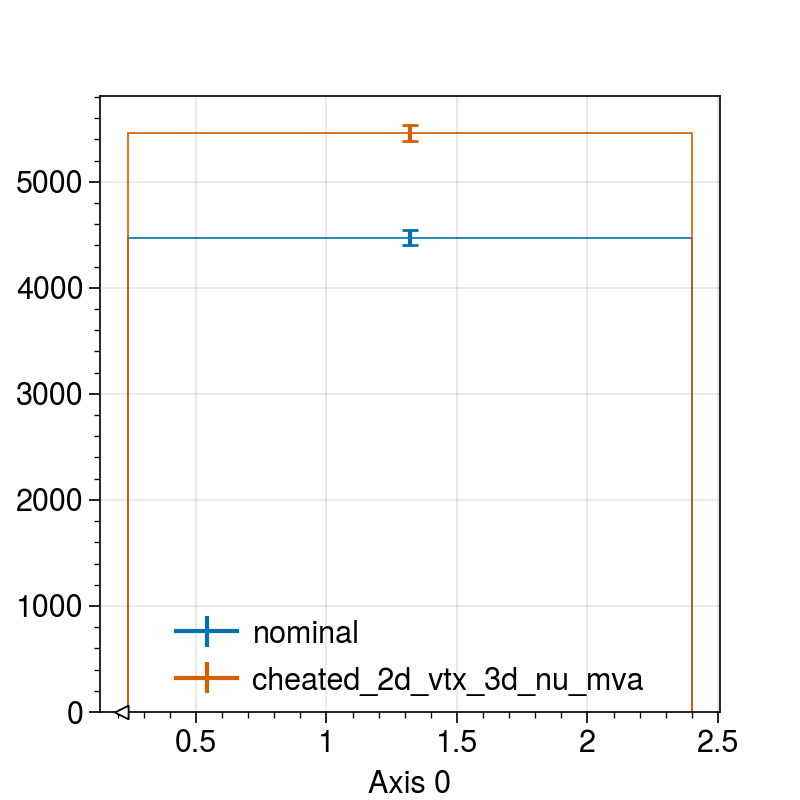

In [55]:
CCNp_data = uproot.open('CCNp_efficiency.root:efficiency_studies')
CCNp_analysis = Analysis(CCNp_data, hist.axis.Regular(1, 0.24, 2.4))
# CCNp_analysis.binning = hist.axis.Regular(55, 0, 1, flow=False)
CCNp_analysis.spectra('nominal', 'sliceEfficiency')[0].plot(label='nominal')
CCNp_analysis.spectra('cheated_2d_vtx_3d_nu_mva', 'sliceEfficiency')[0].plot(label='cheated_2d_vtx_3d_nu_mva')
plt.legend()

## How we can compute the single step efficiency (or at least how we can try to...)?

I define the starred efficiencies as the efficiency of the cheated algorithms. 

If we assume that the selection efficiencies can be factorized as $\epsilon_\mathrm{2D} \cdot \epsilon_\mathrm{vtx} \cdot \epsilon_\mathrm{3D} \cdot \epsilon_\mathrm{Nu} \cdot \epsilon_\mathrm{TS} \times \epsilon_\mathrm{SEL} = \epsilon$, we can decouple the effect and get the individual efficiencies

[0.54642202]


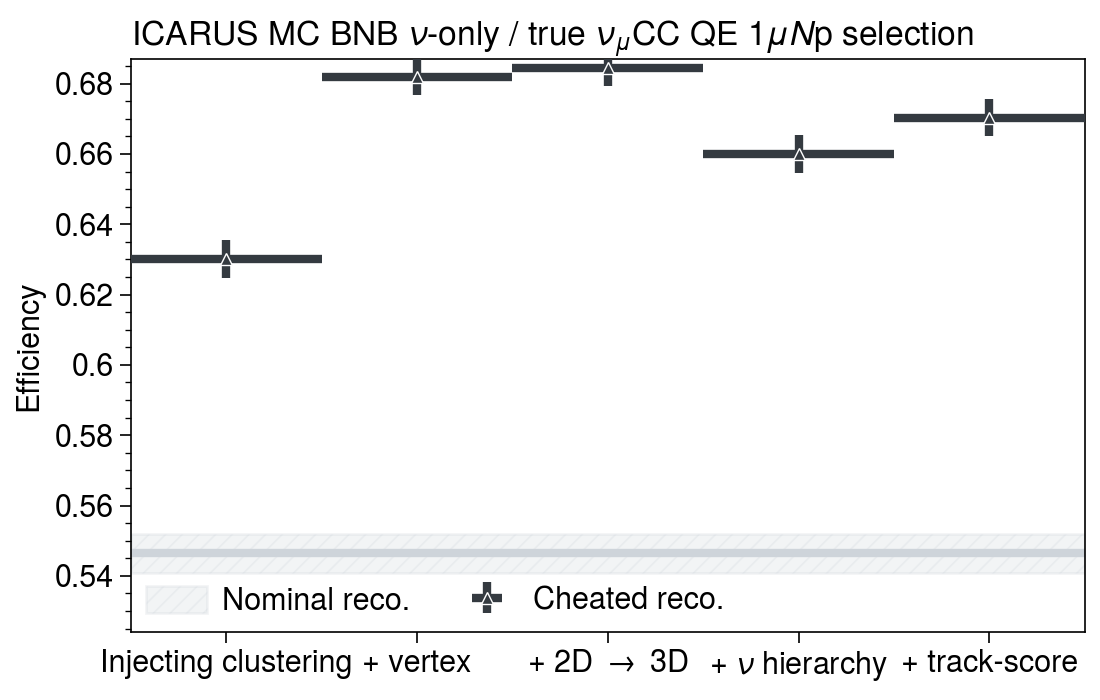

In [56]:
fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection',
    xticks=[0, 1, 2, 3, 4], 
    xticklabels=[
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ],
    # xrotati,
    # urtitle=r'$1\mu N\mathrm{p}$ selection'
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'w', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2d',
    'cheated_2d_vtx',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_nu',
    'cheated_2d_vtx_3d_nu_mva',
]


## NOMINAL RECO
efficiency, (low, high) = CCNp_analysis.efficiency('nominal')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='gray4', ec='gray4', alpha=0.25, linewidth=1, label='Nominal reco.', zorder=-99)
print(efficiency)
ax[0].axhline(efficiency, lw=3, c='gray4')


## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = CCNp_analysis.efficiency(tree)
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='gray8', fmt='^', label=('Cheated reco.' if i==0 else None), zorder=99)

# ax[1].format(urtitle='', ultitle=r'$1\mu1p$ selection')
[axi.legend(loc='ll', ncols=2) for axi in ax]
# [axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

ax.format(ylim=(0.524, 0.687))


fig.savefig('plots_CCNp_test/CCNp_efficiency.pdf', bbox_inches='tight')

nominal: 54.77%
cheated_2d: 63.11%
cheated_2d_vtx: 68.17%
cheated_2d_vtx_3d: 68.49%
cheated_2d_vtx_3d_mva: 69.16%


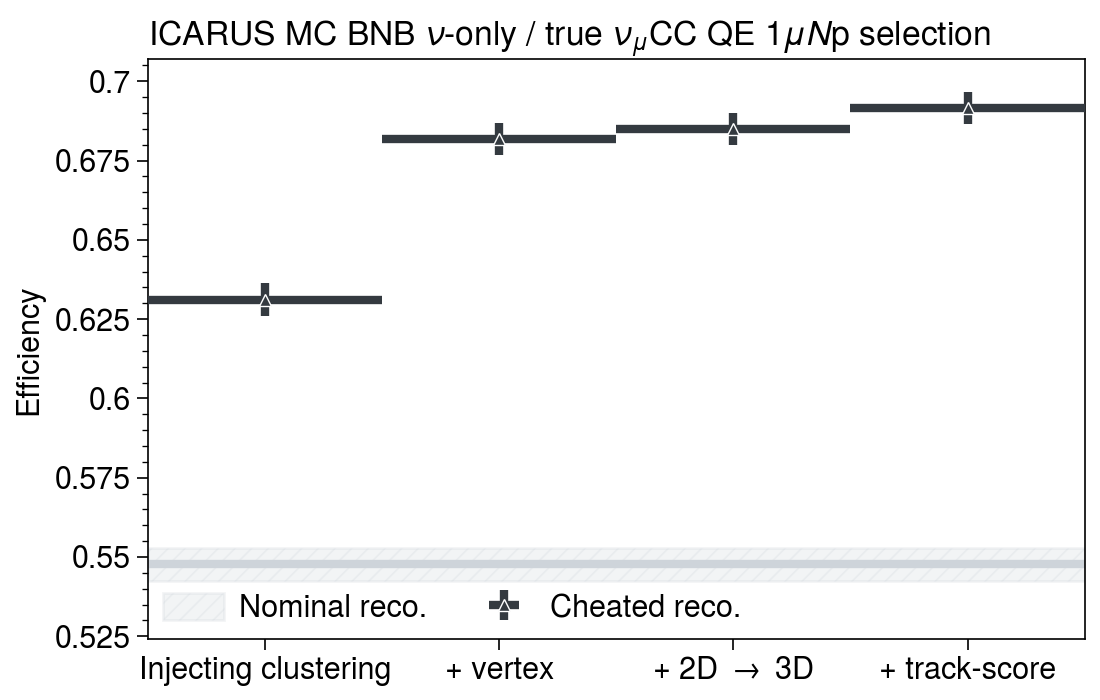

In [57]:
CCNp_data = uproot.open('CCNp_efficiencyNoNu.root:efficiency_studies')
CCNp_analysis = Analysis(CCNp_data, hist.axis.Regular(1, 0.24, 2.4))

fig, ax = plot.subplots(
    width=5.5, height=3.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection',
    xticks=[0, 1, 2, 3], 
    xticklabels=[
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        # '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ],
    # xrotati,
    # urtitle=r'$1\mu N\mathrm{p}$ selection'
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'w', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2d',
    'cheated_2d_vtx',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_mva',
]


## NOMINAL RECO
efficiency, (low, high) = CCNp_analysis.efficiency('nominal')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='gray4', ec='gray4', alpha=0.25, linewidth=1, label='Nominal reco.', zorder=-99)
ax[0].axhline(efficiency, lw=3, c='gray4')

print(f'{'nominal'}: {efficiency[0]:.2%}')

efficiencies = []
sigmas = []
efficiencies.append(efficiency[0])
sigmas.append(np.max([low, high]))

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = CCNp_analysis.efficiency(tree)
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='gray8', fmt='^', label=('Cheated reco.' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')
    efficiencies.append(efficiency[0])
    sigmas.append(np.max(uncertainty))

# ax[1].format(urtitle='', ultitle=r'$1\mu1p$ selection')
[axi.legend(loc='ll', ncols=2) for axi in ax]
# [axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

ax.format(ylim=(0.524, 0.707))


fig.savefig('plots_CCNp_test/CCNp_efficiencyNoNu.pdf', bbox_inches='tight')


nominal: 59.15%
cheated_2d: 63.13%
cheated_2d_vt: 68.19%
cheated_2d_vtx_3d: 68.51%
cheated_2d_vtx_3d_mva: 69.18%
cheated_2d_slicing: 64.02%
cheated_2d_vt_slicing: 69.31%
cheated_2d_vtx_3d_slicing: 69.57%
cheated_2d_vtx_3d_mva_slicing: 70.26%


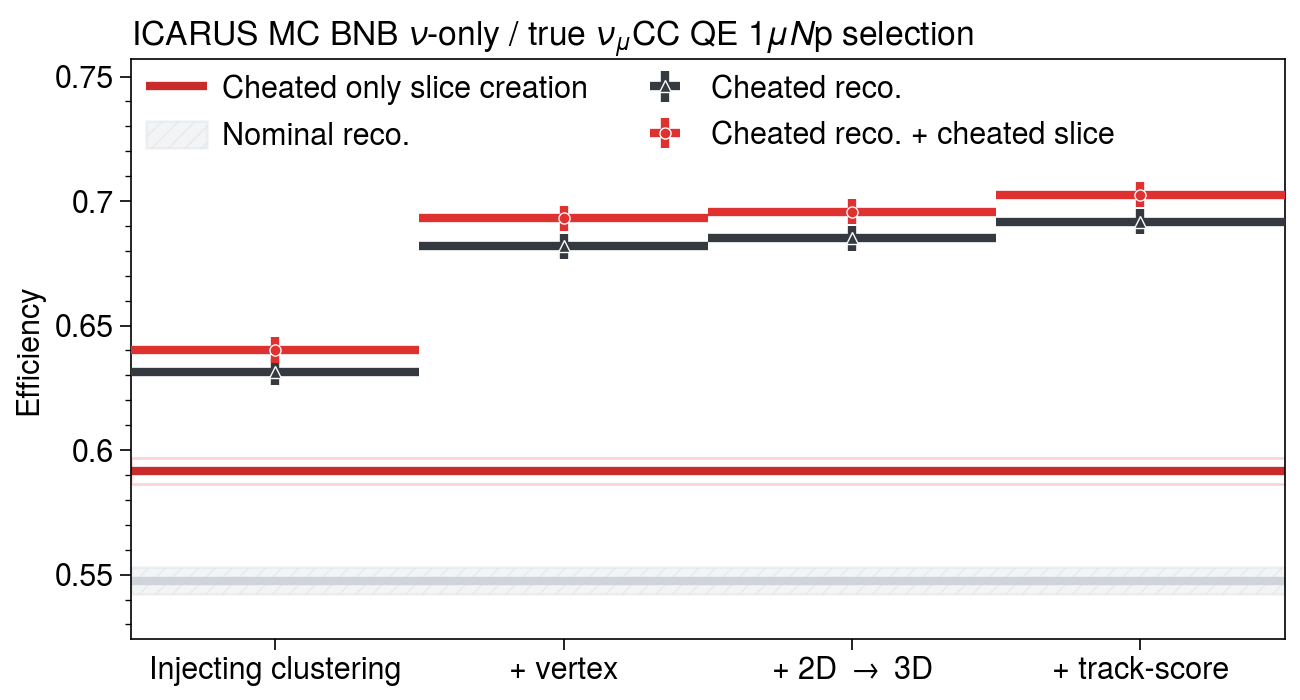

In [58]:
CCNp_data = uproot.open('CCNp_efficiencyNoNu_cheatedSlice.root:efficiency_studies')
CCNp_analysis = Analysis(CCNp_data, hist.axis.Regular(1, 0.24, 2.4))

fig, ax = plot.subplots(
    width=6.5, height=3.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection',
    xticks=[0, 1, 2, 3], 
    xticklabels=[
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        # '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ],
    # xrotati,
    # urtitle=r'$1\mu N\mathrm{p}$ selection'
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'w', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2d',
    'cheated_2d_vt',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_mva',
]

trees_slicing = [
    'cheated_2d_slicing',
    'cheated_2d_vt_slicing',
    'cheated_2d_vtx_3d_slicing',
    'cheated_2d_vtx_3d_mva_slicing',
]


## NOMINAL RECO
efficiency, (low, high) = CCNp_analysis.efficiency('nominal')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='gray4', ec='gray4', alpha=0.25, linewidth=1, label='Nominal reco.', zorder=-99)
ax[0].axhline(efficiency, lw=3, c='gray4')

efficiency, (low, high) = CCNp_analysis.efficiency('cheated_slicing')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], fill=False, color='red6', ec='red6', alpha=0.25, linewidth=1, zorder=-99)
ax[0].axhline(efficiency, lw=3, c='red9', label='Cheated only slice creation')

print(f'{'nominal'}: {efficiency[0]:.2%}')

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = CCNp_analysis.efficiency(tree)
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='gray8', fmt='^', label=('Cheated reco.' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')

for i, tree in enumerate(trees_slicing):
    efficiency, uncertainty = CCNp_analysis.efficiency(tree)
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='red8', fmt='o', label=('Cheated reco. + cheated slice' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')

# ax[1].format(urtitle='', ultitle=r'$1\mu1p$ selection')
[axi.legend(loc='ul', ncols=2, order='F') for axi in ax]
# [axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

ax.format(ylim=(0.524, 0.757))


fig.savefig('plots_CCNp_test/CCNp_efficiencyNoNu_cheatingSlice.pdf', bbox_inches='tight')


In [59]:
analysis = pd.DataFrame({
    'value': efficiencies,
    'uncertainty': sigmas
})

# Compute ratios and propagated uncertainties
ratios = analysis['value'].iloc[:-1].values / analysis['value'].iloc[1:].values
errors = ratios * np.sqrt(
    (analysis['uncertainty'].iloc[1:].values / analysis['value'].iloc[1:].values) ** 2 +
    (analysis['uncertainty'].iloc[:-1].values / analysis['value'].iloc[:-1].values) ** 2
)

# Store results
result = pd.DataFrame({
    'ratio': ratios*100,
    'uncertainty': errors*100
}, index=analysis.index[1:])
result

,ratio,uncertainty
1,86.779059,1.104354
2,92.575370,1.024352
3,99.526687,1.041368
4,99.039894,1.024644


In [60]:
analysis

,value,uncertainty
0,0.547654,0.005328
1,0.631090,0.005177
2,0.681704,0.005062
3,0.684946,0.005049
4,0.691586,0.005021


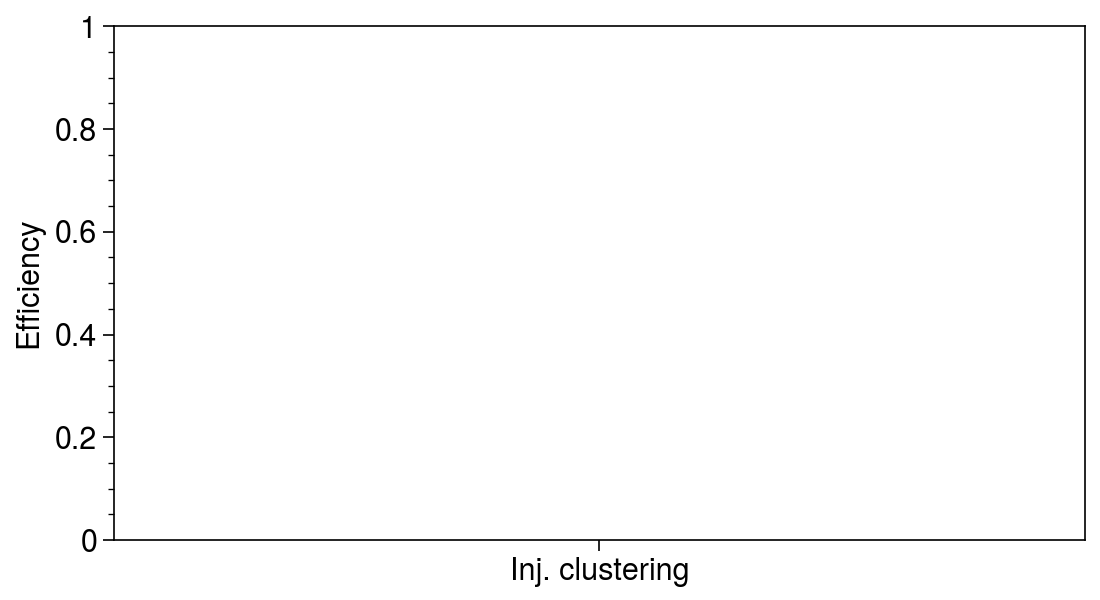

In [61]:
fig, ax = plot.subplots(
    width=5.5, height=3, ncols=1, nrows=1, ylabel='Efficiency',
    titlecolor='k', share=False, grid=False, sharex=True,
    xticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], 
    xticklabels=[
        'Inj. clustering', 
        'Inj. vertex', 
        'Inj. vertex\nselection', 
        'Inj. 3D match',
        'Inj. $\\nu$\ntopology',
        'Inj. track-score'
    ],
    # xrotation=35,
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'k', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2d',
    'cheated_vtx',
    'cheated_vtxSelection',
    'cheated_3d',
    'cheated_nuH',
    'cheated_mva'
]


## NOMINAL RECO

# for hatch, reco, label in zip(['////', '...'], ['nominal', 'cheated_2d_vtx_3d_nu_mva'], ['Nominal reconstruction', 'Full cheated reconstruciton']):
#     efficiency, (low, high) = CCNp_analysis.efficiency(reco)
#     ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch=hatch, fill=False, ec='red4', alpha=0.75, linewidth=1, label=label)
#     ax[0].axhline(efficiency, lw=3, c='red4')

# ## LADDER 
# for i, tree in enumerate(trees):
#     efficiency, uncertainty = CCNp_analysis.efficiency(tree)
#     ax[0].errorbar(i+0.5, efficiency, yerr=uncertainty, **cheated_dict, color='red8', fmt='^', label=('Cheated reco.' if i==0 else None))

# ax[0].format(rtitle=r'ICARUS MC BNB / $\nu$-only / $1\mu N\mathrm{p}$ selection')
# ax[0].legend(ncols=1, loc='ll', frameon=True)
# [ax[0].set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

# fig.savefig('plots_CCNp_test/CCNp_efficiency_singles.pdf', bbox_inches='tight')

In [62]:
stage1_dict = {
        'cheated_2d': 'Cheated clustering',
        'cheated_vtx': 'Cheated vertex',
        'cheated_vtxSelection': 'Cheated vertex selection',
        'cheated_3d': 'Cheated 3D matching',
        'cheated_nuH': r'Cheated $\nu$-hierarchy',
        'cheated_mva': 'Cheated track-score',
        'nominal': 'Nominal reconstruction'
}

def plot_selections(data, stage1='cheated_2d'):

    energy_bins=hist.axis.Regular(18, 0.24, 2.4)
    analysis_1u1p = Analysis(data=data, binning=energy_bins)
    analysis_1u1p_integrated = Analysis(data=data, binning=hist.axis.Regular(1, 0.24, 2.4))
    
    fig, axs = plot.subplots(
        width=6.5, height=4.5, ncols=1, nrows=1, ylabel=f'Selected spills / {energy_bins.widths[0]:.2f} GeV',
        titlecolor='k', share=False, grid=False, 
        xlabel='Neutrino true (GeV)',
        rtitle=f'ICARUS MC BNB / $\\nu$-only $1\\mu1p$ / {stage1_dict[stage1]}', 
        ltitle='Work in progress'
    )

    ax = axs[0]

    reco_true, _, true = analysis_1u1p.spectra(stage1, 's7')
    hep.histplot(true, ax=ax, histtype='fill', color='gray1')

    
    
    selections = {
        's1': 'CRT-PMT match',
        's2': 'Flash-match',
        's3': 'Vertex in FV',
        's4': 'Containment',
        's5': r'$\mu$ ID',
        's6': 'Proton ID',
        's7': r'$0\pi$ and $0\gamma$'
    }

    cidx = 6

    selection_colors = {
        's1': f'yellow{cidx}',
        's3': f'lime{cidx}',
        's2': f'blue{cidx}',
        's4': f'orange{cidx}',
        's5': f'red{cidx}',
        's6': f'pink{cidx}',
        's7': f'indigo{cidx}',
    }

        

    secax = ax.alty(label=f'Efficiency / {energy_bins.widths[0]:.2f} GeV')
    
    for key in selections:
        efficiency, uncertainty = analysis_1u1p.efficiency(stage1, key)
        integrated_efficiency, _ = analysis_1u1p_integrated.efficiency(stage1, key)
        secax.errorbar(energy_bins.centers, efficiency, yerr=uncertainty, xerr=energy_bins.widths[0]/2, color=selection_colors[key],
                       fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.5,
                       label='{} ({:.1f} %)'.format(selections[key], integrated_efficiency[0]*100))


    secax.format(ymax=1.25)
    ax.format(ymax=1350)
    secax.legend(order='C', mode='extend')
    

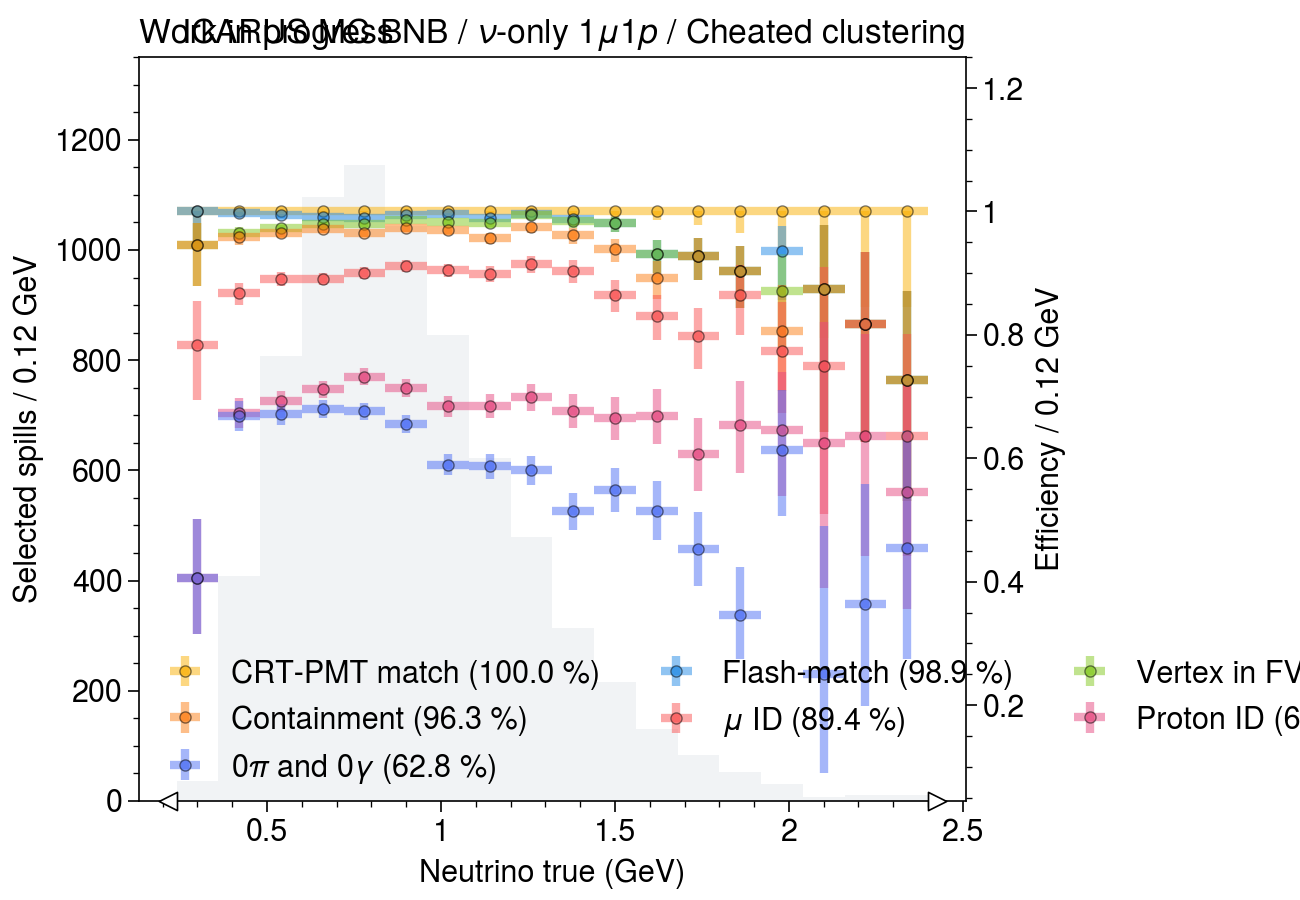

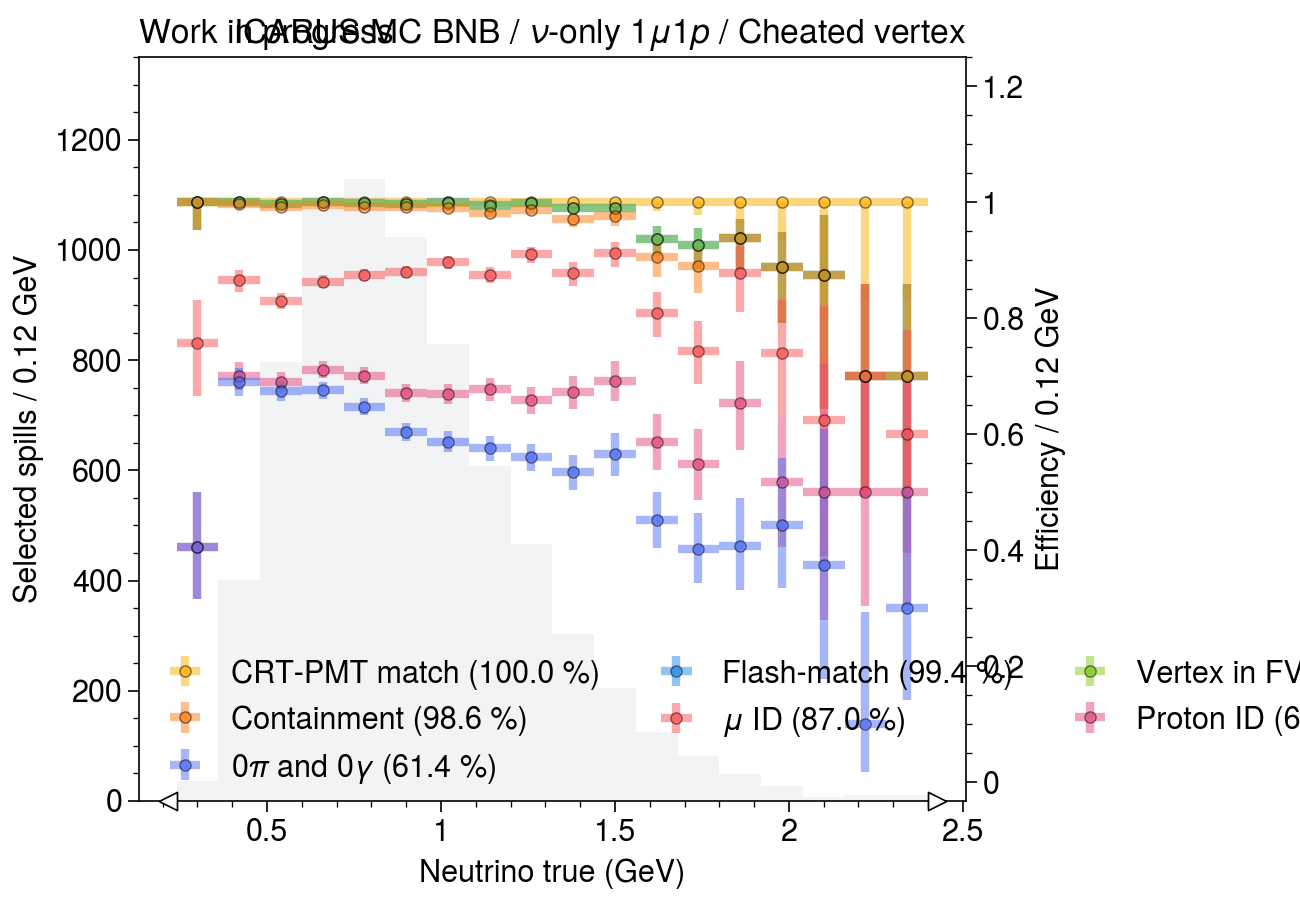

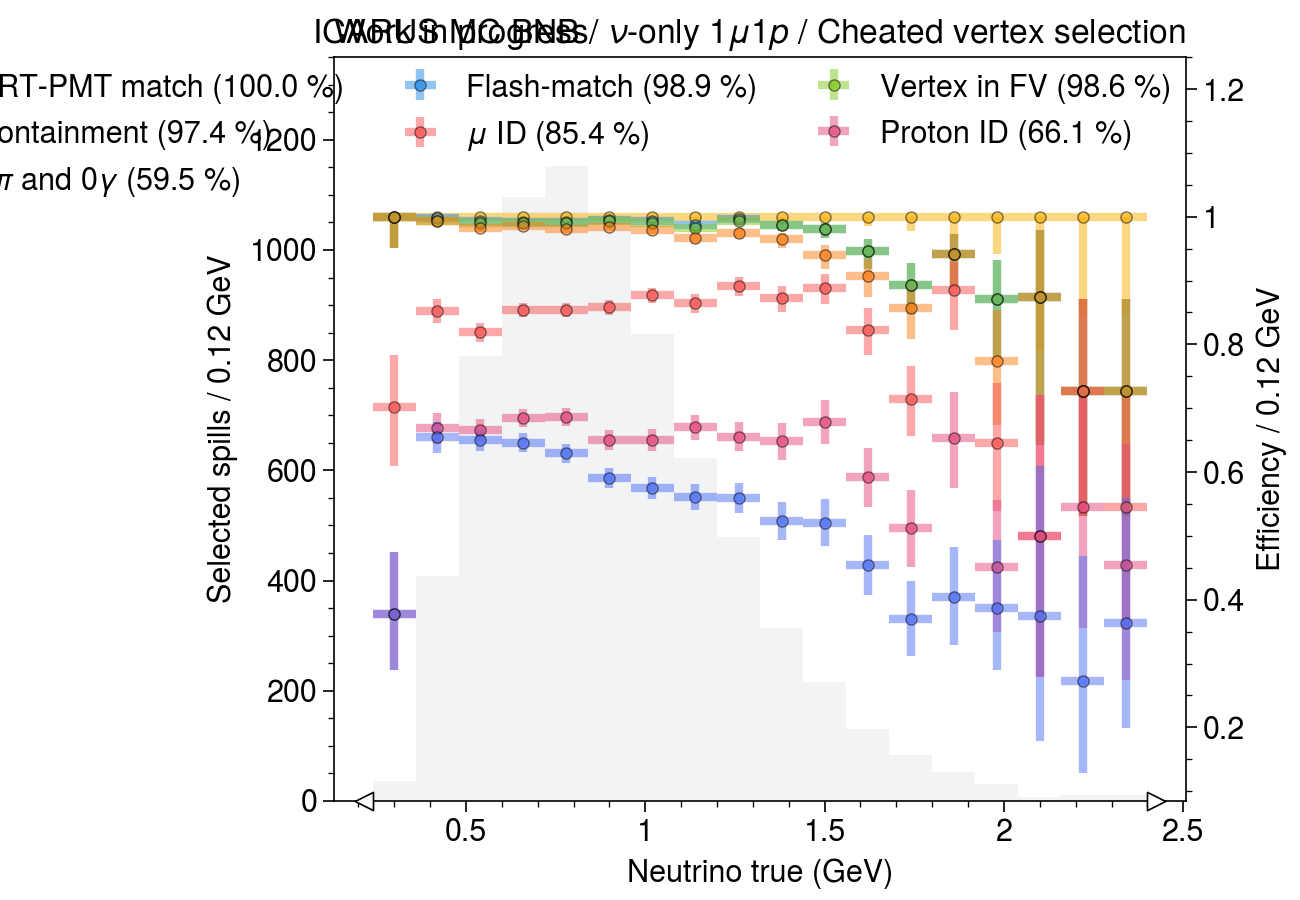

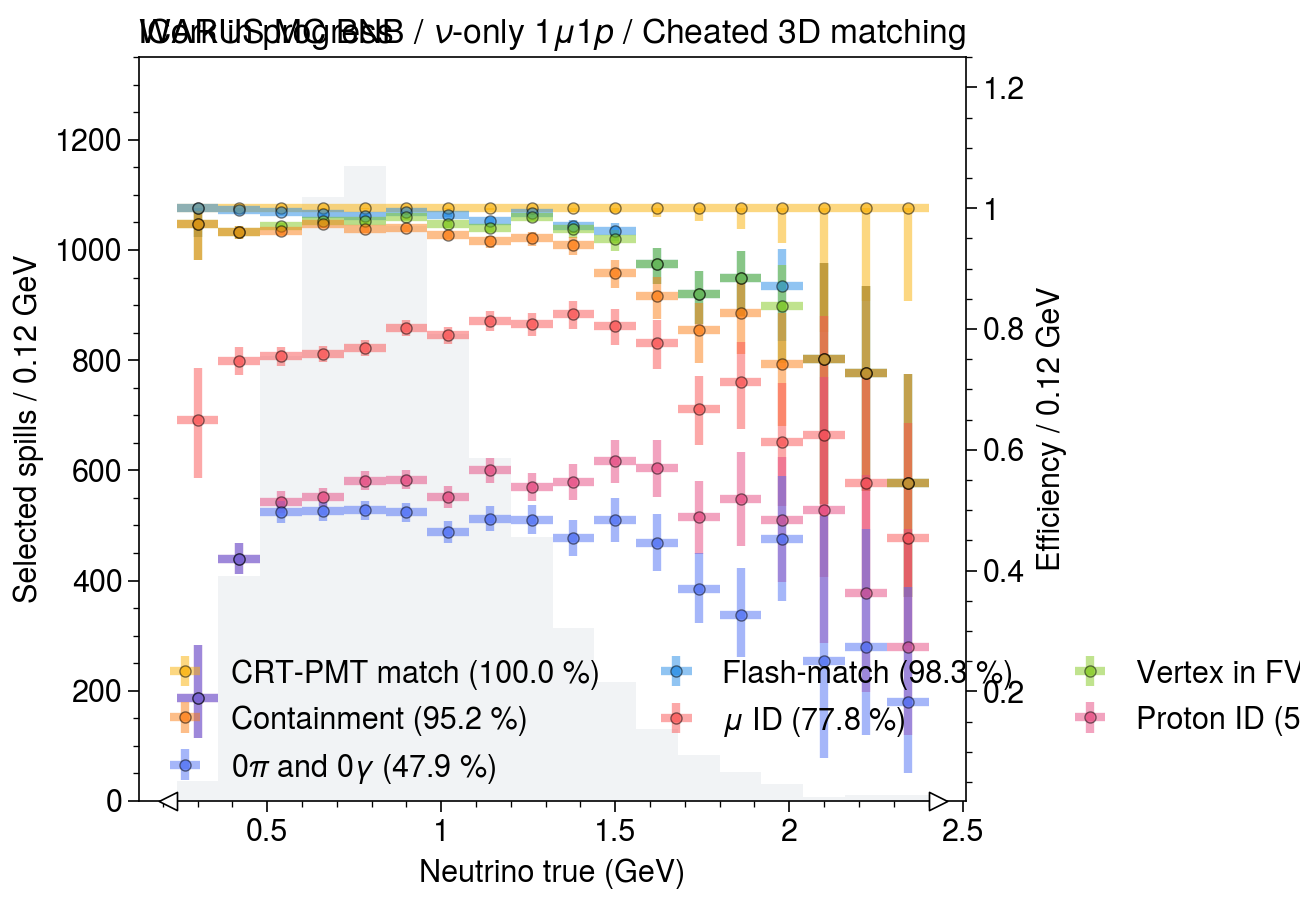

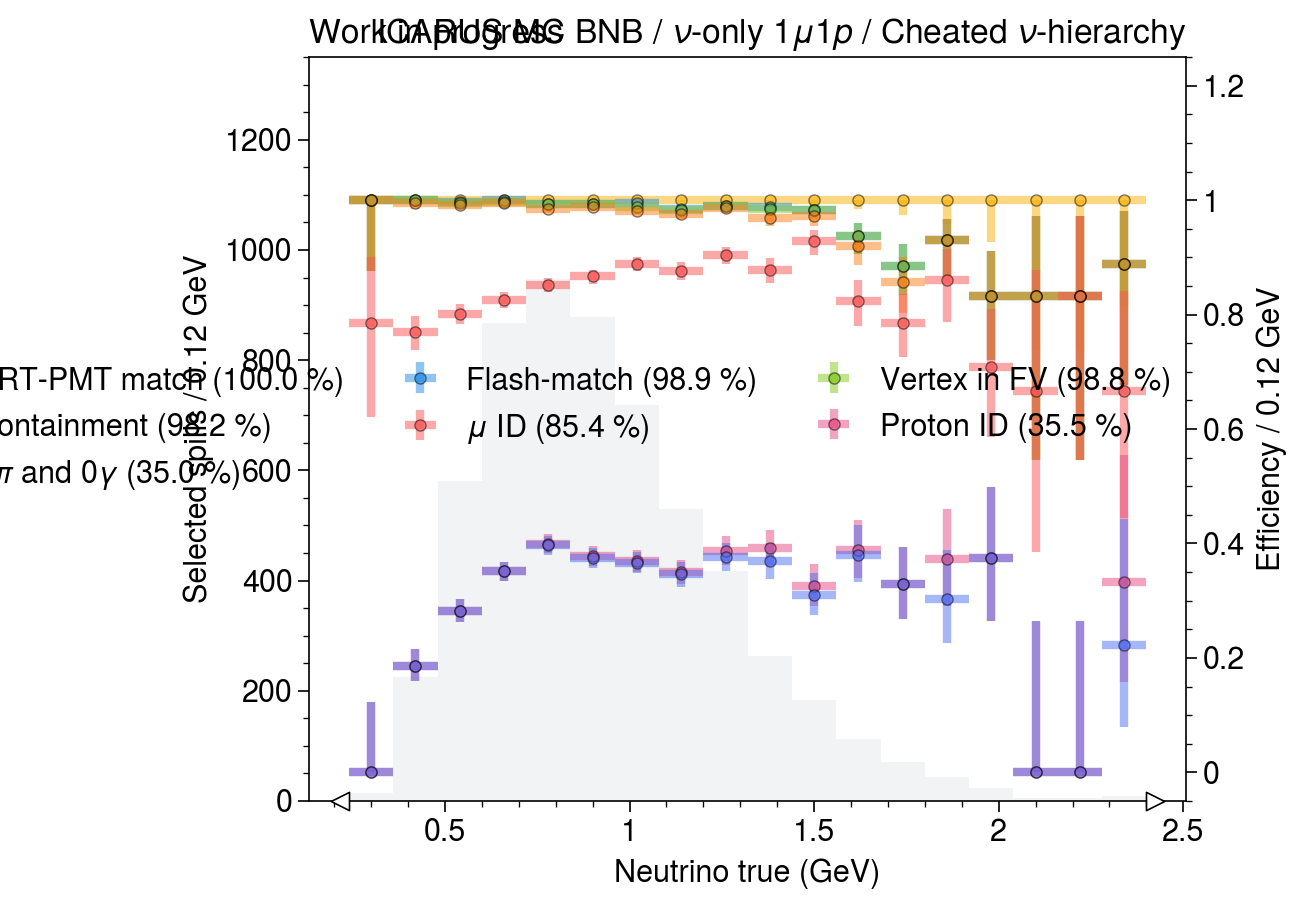

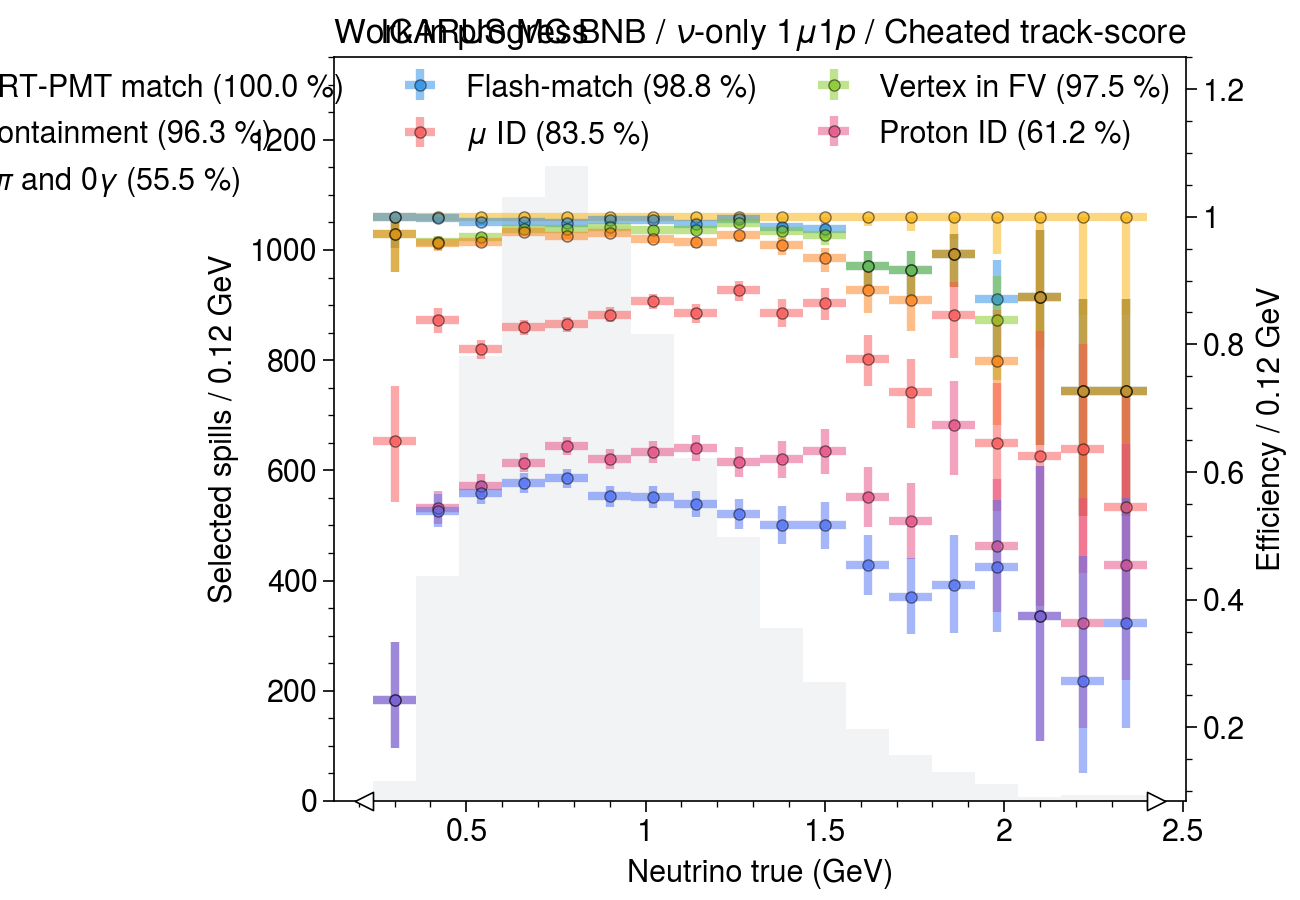

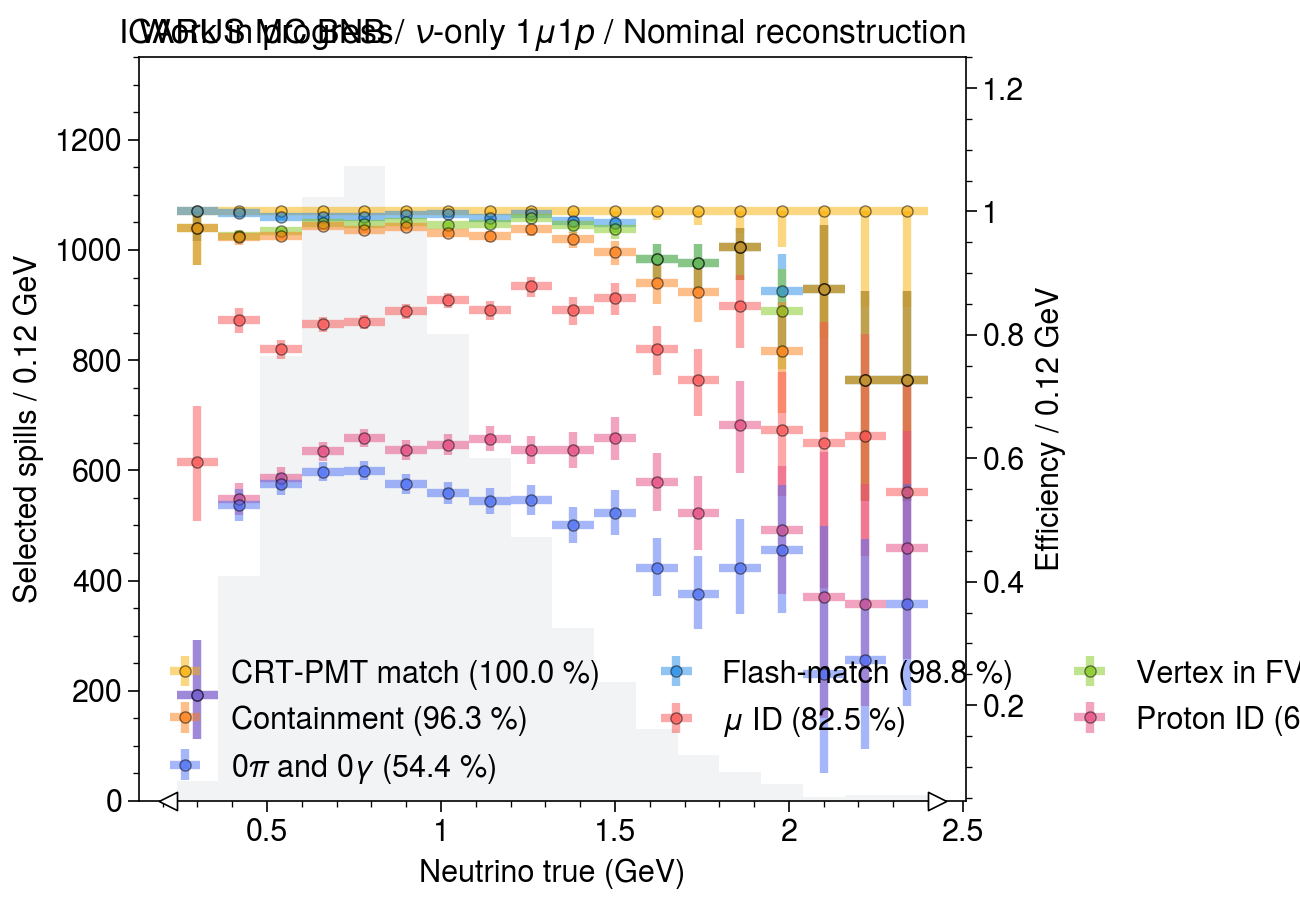

In [63]:
data = uproot.open('CCNp_efficiency_byCut.root:cuts')

for stage in stage1_dict:
    plot_selections(data, stage)

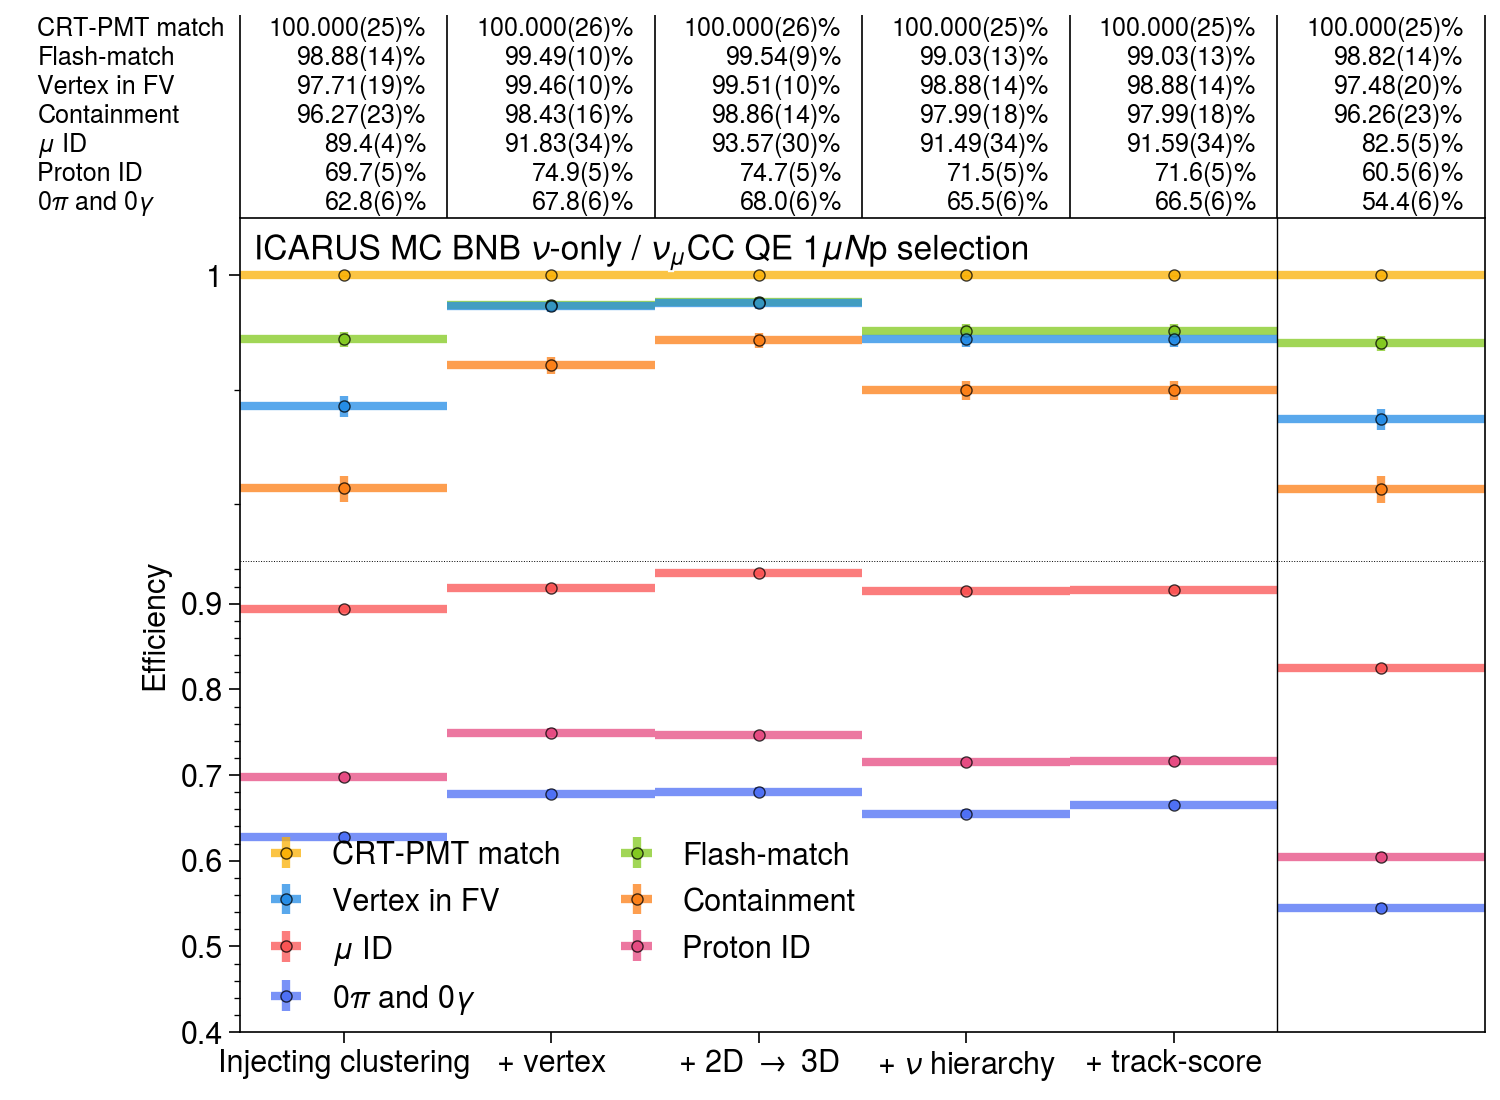

In [64]:
from uncertainties import ufloat

colllabels = [
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ]

fig, ax = plot.subplots(
    width=7.5, height=5.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ultitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xticks=[0, 1, 2, 3, 4], 
    xticklabels=colllabels,
    # xrotati,
    # , yscale='log'
)


cidx = 6

selections = {
        's1': ('CRT-PMT match', f'yellow{cidx}'), 
        's2': ('Flash-match', f'lime{cidx}'), 
        's3': ('Vertex in FV', f'blue{cidx}'), 
        's4': (r'Containment', f'orange{cidx}'), 
        's5': (r'$\mu$ ID', f'red{cidx}'), 
        's6': (r'Proton ID', f'pink{cidx}'), 
        's7': (r'$0\pi$ and $0\gamma$', f'indigo{cidx}')
}


trees = [
    'cheated_2d',
    'cheated_2d_vtx',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_nu',
    'cheated_2d_vtx_3d_nu_mva',
    'nominal',
]

CCNp_efficiency_byCut = Analysis(data, hist.axis.Regular(1, 0.24, 2.4))

cell_text = []
rowLabel = []
rowColor = []

for i, stage in enumerate(trees):
    for cut in selections:
        
        efficiency, uncertainty = CCNp_efficiency_byCut.efficiency(stage, cut)
        integrated_efficiency, _ = CCNp_efficiency_byCut.efficiency(stage, cut)
        label, color = selections[cut]
        if i == 0: 
            rowLabel.append(label)
            rowColor.append(color)
        ax.errorbar(i, efficiency, yerr=uncertainty, xerr=0.5, color=color,
                    fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                    label=('{}'.format(label) if i==0 else None))
        # cell_text.append(f'${efficiency[0]*100:.1f}\\pm{uncertainty[0][0]*100:.1f}$%')
        cell_text.append(f'${ufloat(efficiency[0]*100, np.max(uncertainty)*100):uSL}$%')
        
ax.table(cellText=np.array(cell_text).reshape((6,7)).T, loc='top', edges='R', rowLabels=rowLabel, rowColours=rowColor)

ax.axvline(4.5, color='k', lw=0.5)
ax.axhline(0.95, color='k', lw=0.35, ls=':')
ax.format(yscale=plot.scale.CutoffScale(0.95, 0.15), ymin=0.4, ymax=1.01)
ax.legend(ncols=2, loc='ll', order='C')

fig.savefig('plots_CCNp_test/CCNp_efficiencyByCut.pdf', bbox_inches='tight')

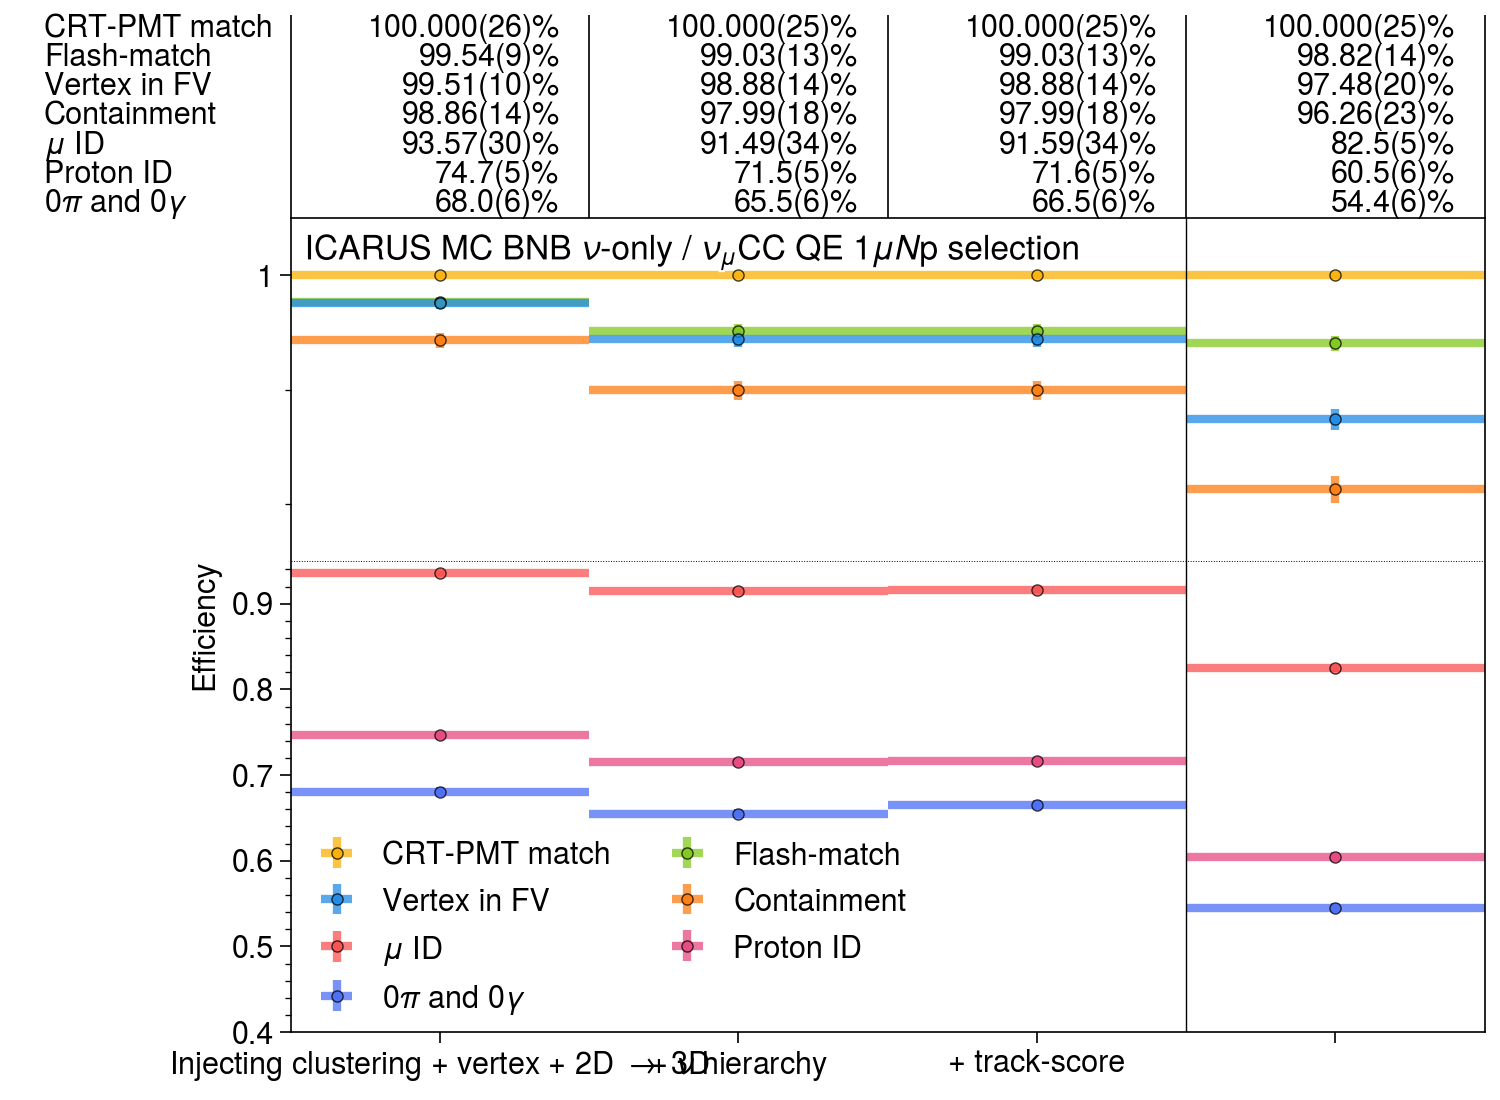

In [65]:
from uncertainties import ufloat

colllabels = [
        # 'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        # '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        'Injecting clustering + vertex + 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ]

fig, ax = plot.subplots(
    width=7.5, height=5.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ultitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xticks=[0, 1, 2, 3, 4], 
    xticklabels=colllabels,
    # xrotati,
    # , yscale='log'
)


cidx = 6

selections = {
        's1': ('CRT-PMT match', f'yellow{cidx}'), 
        's2': ('Flash-match', f'lime{cidx}'), 
        's3': ('Vertex in FV', f'blue{cidx}'), 
        's4': (r'Containment', f'orange{cidx}'), 
        's5': (r'$\mu$ ID', f'red{cidx}'), 
        's6': (r'Proton ID', f'pink{cidx}'), 
        's7': (r'$0\pi$ and $0\gamma$', f'indigo{cidx}')
}


trees = [
    # 'cheated_2d',
    # 'cheated_2d_vtx',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_nu',
    'cheated_2d_vtx_3d_nu_mva',
    'nominal',
]

CCNp_efficiency_byCut = Analysis(data, hist.axis.Regular(1, 0.24, 2.4))

cell_text = []
rowLabel = []
rowColor = []

for i, stage in enumerate(trees):
    for cut in selections:
        
        efficiency, uncertainty = CCNp_efficiency_byCut.efficiency(stage, cut)
        integrated_efficiency, _ = CCNp_efficiency_byCut.efficiency(stage, cut)
        label, color = selections[cut]
        if i == 0: 
            rowLabel.append(label)
            rowColor.append(color)
        ax.errorbar(i, efficiency, yerr=uncertainty, xerr=0.5, color=color,
                    fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                    label=('{}'.format(label) if i==0 else None))
        # cell_text.append(f'${efficiency[0]*100:.1f}\\pm{uncertainty[0][0]*100:.1f}$%')
        cell_text.append(f'${ufloat(efficiency[0]*100, np.max(uncertainty)*100):uSL}$%')
        
ax.table(cellText=np.array(cell_text).reshape((4,7)).T, loc='top', edges='R', rowLabels=rowLabel, rowColours=rowColor)

ax.axvline(2.5, color='k', lw=0.5)
ax.axhline(0.95, color='k', lw=0.35, ls=':')
ax.format(yscale=plot.scale.CutoffScale(0.95, 0.15), ymin=0.4, ymax=1.01)
ax.legend(ncols=2, loc='ll', order='C')

fig.savefig('plots_CCNp_test/CCNp_efficiencyByCut_onlyThreeLast.pdf', bbox_inches='tight')

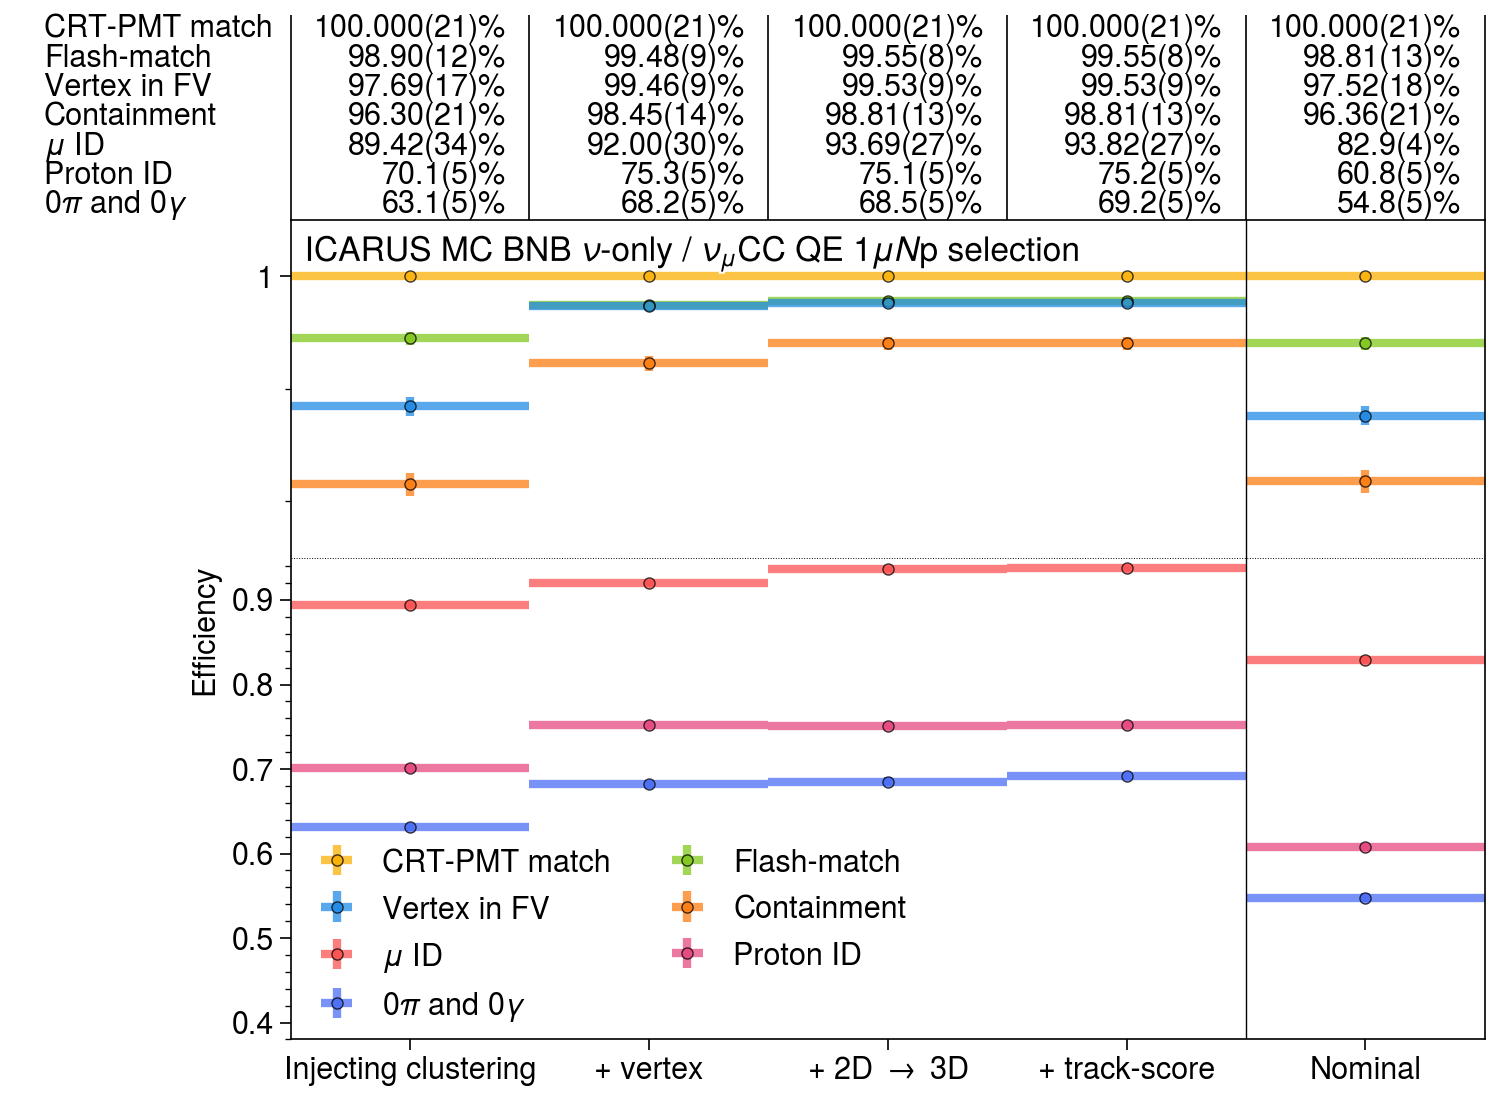

In [66]:
colllabels = [
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        # '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score', # 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
        'Nominal'
    ]

fig, ax = plot.subplots(
    width=7.5, height=5.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ultitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xticks=[0, 1, 2, 3, 4], 
    xticklabels=colllabels,
    # xrotati,
    # , yscale='log'
)


cidx = 6

selections = {
        's1': ('CRT-PMT match', f'yellow{cidx}'), 
        's2': ('Flash-match', f'lime{cidx}'), 
        's3': ('Vertex in FV', f'blue{cidx}'), 
        's4': (r'Containment', f'orange{cidx}'), 
        's5': (r'$\mu$ ID', f'red{cidx}'), 
        's6': (r'Proton ID', f'pink{cidx}'), 
        's7': (r'$0\pi$ and $0\gamma$', f'indigo{cidx}')
}


trees = [
    'cheated_2d',
    'cheated_2d_vt',
    'cheated_2d_vtx_3d',
    # 'cheated_2d_vtx_3d_nu',
    'cheated_2d_vtx_3d_mva',
    'nominal',
]

CCNp_efficiency_byCut = Analysis(uproot.open('CCNp_efficiencyByCut_noNu_cheatingSlice.root:cuts'), hist.axis.Regular(1, 0.24, 2.4))

cell_text = []
rowLabel = []
rowColor = []

for i, stage in enumerate(trees):
    for cut in selections:
        
        efficiency, uncertainty = CCNp_efficiency_byCut.efficiency(stage, cut)
        integrated_efficiency, _ = CCNp_efficiency_byCut.efficiency(stage, cut)
        label, color = selections[cut]
        if i == 0: 
            rowLabel.append(label)
            rowColor.append(color)
        ax.errorbar(i, efficiency, yerr=uncertainty, xerr=0.5, color=color,
                    fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                    label=('{}'.format(label) if i==0 else None))
        # cell_text.append(f'${efficiency[0]*100:.1f}\\pm{uncertainty[0][0]*100:.1f}$%')
        cell_text.append(f'${ufloat(efficiency[0]*100, np.max(uncertainty)*100):uSL}$%')
        
ax.table(cellText=np.array(cell_text).reshape((5,7)).T, loc='top', edges='R', rowLabels=rowLabel, rowColours=rowColor)

ax.axvline(3.5, color='k', lw=0.5)
ax.axhline(0.95, color='k', lw=0.35, ls=':')
ax.format(yscale=plot.scale.CutoffScale(0.95, 0.15), ymin=0.38, ymax=1.01)
ax.legend(ncols=2, loc='ll', order='C')

fig.savefig('plots_CCNp_test/CCNp_efficiencyByCut_noNu_cheatingSlice.pdf', bbox_inches='tight')

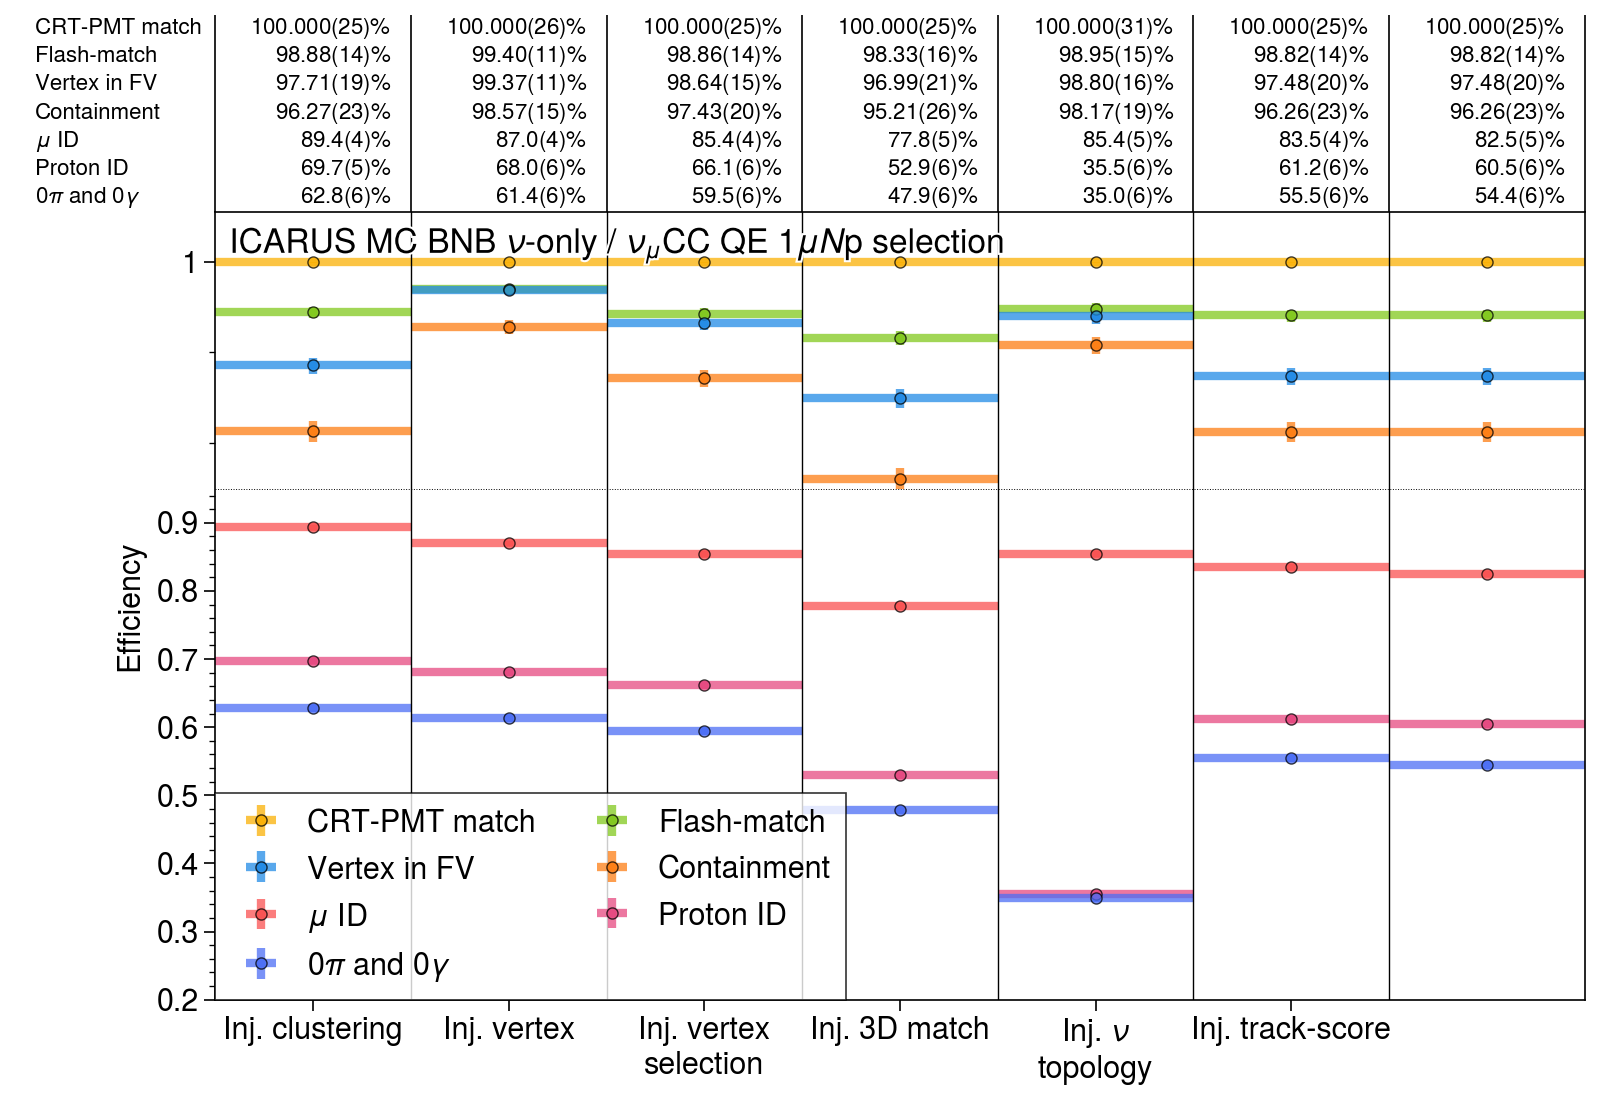

In [67]:

fig, ax = plot.subplots(
    width=8, height=5.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ultitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xticks=[0, 1, 2, 3, 4, 5, ], 
    xticklabels=[
        'Inj. clustering', 
        'Inj. vertex', 
        'Inj. vertex\nselection', 
        'Inj. 3D match',
        'Inj. $\\nu$\ntopology',
        'Inj. track-score', 
    ],
)


cidx = 6

selections = {
        's1': ('CRT-PMT match', f'yellow{cidx}'), 
        's2': ('Flash-match', f'lime{cidx}'), 
        's3': ('Vertex in FV', f'blue{cidx}'), 
        's4': (r'Containment', f'orange{cidx}'), 
        's5': (r'$\mu$ ID', f'red{cidx}'), 
        's6': (r'Proton ID', f'pink{cidx}'), 
        's7': (r'$0\pi$ and $0\gamma$', f'indigo{cidx}')
}


trees = [
    'cheated_2d',
    'cheated_vtx',
    'cheated_vtxSelection',
    'cheated_3d',
    'cheated_nuH',
    'cheated_mva',
    'nominal',
]

CCNp_efficiency_byCut = Analysis(data, hist.axis.Regular(1, 0.24, 2.4))

cell_text = []
rowLabel = []
rowColor = []

for i, stage in enumerate(trees):
    for cut in selections:
        
        efficiency, uncertainty = CCNp_efficiency_byCut.efficiency(stage, cut)
        integrated_efficiency, _ = CCNp_efficiency_byCut.efficiency(stage, cut)
        label, color = selections[cut]
        if i == 0: 
            rowLabel.append(label)
            rowColor.append(color)
        ax.errorbar(i, efficiency, yerr=uncertainty, xerr=0.5, color=color,
                    fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                    label=('{}'.format(label) if i==0 else None))
        cell_text.append(f'${ufloat(efficiency[0]*100, np.max(uncertainty)*100):uSL}$%')

ax.table(cellText=np.array(cell_text).reshape((7,7)).T, loc='top', edges='R', rowLabels=rowLabel, rowColours=rowColor)

[ax.axvline(i+0.5, color='k', lw=0.5) for i in range(0, 6)]
ax.axhline(0.95, color='k', lw=0.35, ls=':')
ax.format(yscale=plot.scale.CutoffScale(0.95, 0.15), ymin=0.2, ymax=1.011)
ax.legend(ncols=2, loc='ll', order='C', frameon=True)

fig.savefig('plots_CCNp_test/toSlide_cutBased_singles.pdf', bbox_inches='tight')


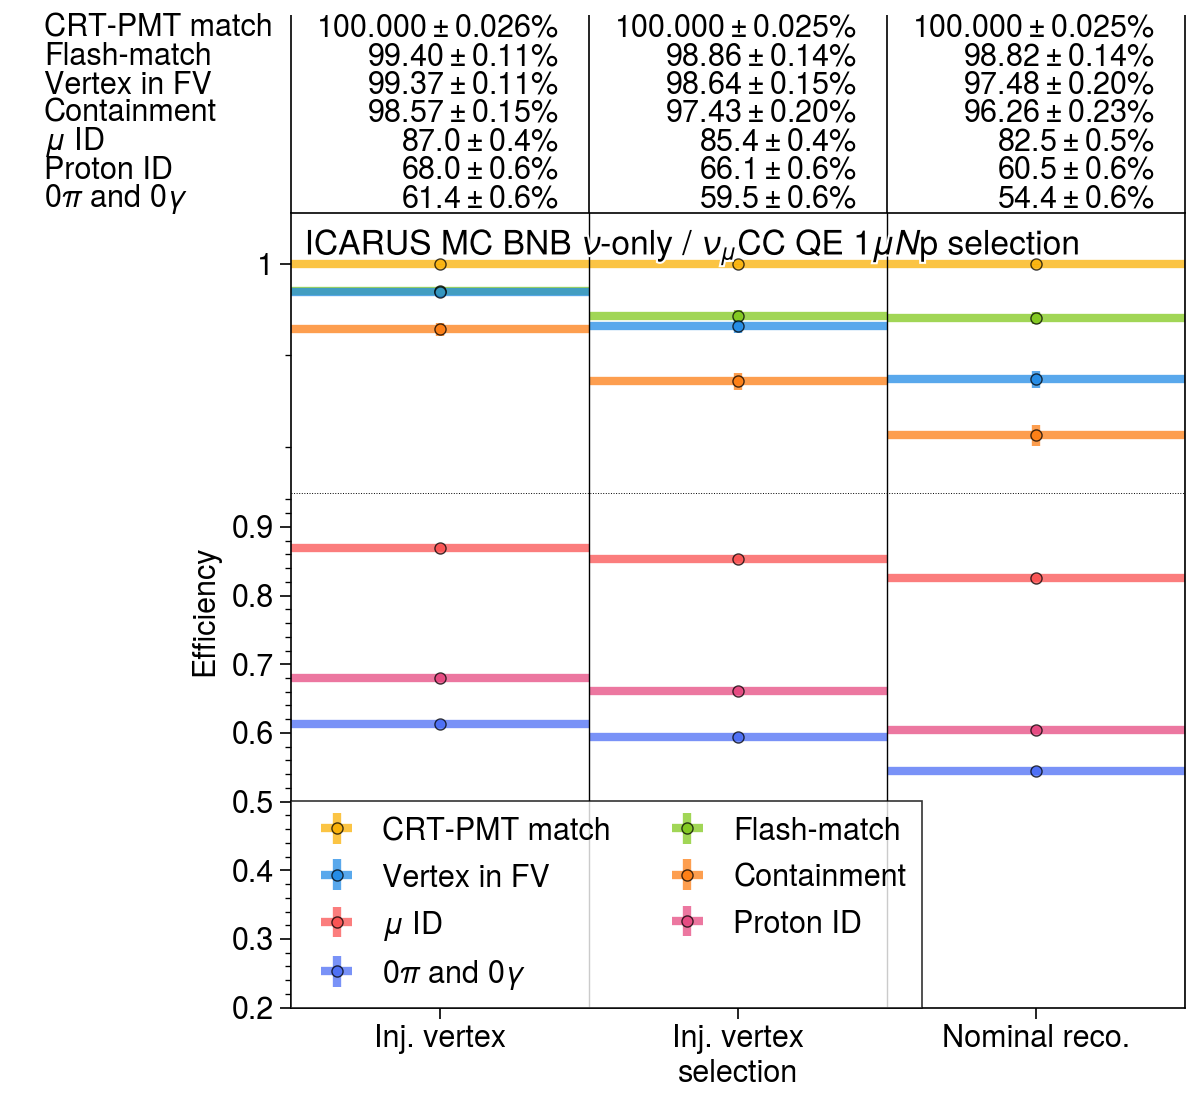

In [68]:

fig, ax = plot.subplots(
    width=6, height=5.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ultitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xticks=[0, 1, 2, ], 
    xticklabels=[
        # 'Inj. clustering', 
        'Inj. vertex', 
        'Inj. vertex\nselection', 
        # 'Inj. 3D match',
        # 'Inj. $\\nu$\ntopology',
        # 'Inj. track-score',
        'Nominal reco.'
    ],
)


cidx = 6

selections = {
        's1': ('CRT-PMT match', f'yellow{cidx}'), 
        's2': ('Flash-match', f'lime{cidx}'), 
        's3': ('Vertex in FV', f'blue{cidx}'), 
        's4': (r'Containment', f'orange{cidx}'), 
        's5': (r'$\mu$ ID', f'red{cidx}'), 
        's6': (r'Proton ID', f'pink{cidx}'), 
        's7': (r'$0\pi$ and $0\gamma$', f'indigo{cidx}')
}


trees = [
    # 'cheated_2d',
    'cheated_vtx',
    'cheated_vtxSelection',
    # 'cheated_3d',
    # 'cheated_nuH',
    # 'cheated_mva',
    'nominal',
]

CCNp_efficiency_byCut = Analysis(data, hist.axis.Regular(1, 0.24, 2.4))

cell_text = []
rowLabel = []
rowColor = []

for i, stage in enumerate(trees):
    for cut in selections:
        
        efficiency, uncertainty = CCNp_efficiency_byCut.efficiency(stage, cut)
        integrated_efficiency, _ = CCNp_efficiency_byCut.efficiency(stage, cut)
        label, color = selections[cut]
        if i == 0: 
            rowLabel.append(label)
            rowColor.append(color)
        ax.errorbar(i, efficiency, yerr=uncertainty, xerr=0.5, color=color,
                    fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                    label=('{}'.format(label) if i==0 else None))
        cell_text.append(f'${ufloat(efficiency[0]*100, np.max(uncertainty)*100):uL}$%')

ax.table(cellText=np.array(cell_text).reshape((3,7)).T, loc='top', edges='R', rowLabels=rowLabel, rowColours=rowColor)

[ax.axvline(i+0.5, color='k', lw=0.5) for i in range(0, len(trees))]
ax.axhline(0.95, color='k', lw=0.35, ls=':')
ax.format(yscale=plot.scale.CutoffScale(0.95, 0.15), ymin=0.2, ymax=1.011)
ax.legend(ncols=2, loc='ll', order='C', frameon=True)


fig.savefig('plots_CCNp_test/CCNp_efficiencyByCut_singles_2d_vtx_only.pdf', bbox_inches='tight')

In [69]:
CCNp_nominal_recoTrue = data['reco_true_cheated_2d_vtx_3d'].arrays(library='pd')
CCNp_nuH_recoTrue = data['reco_true_cheated_2d_vtx_3d_nu'].arrays(library='pd')

In [70]:
# Apply the conditions
condition1 = CCNp_nominal_recoTrue['s7'] > 0  # s8 > 0 in first dataframe
condition2 = CCNp_nuH_recoTrue['s7'] < 0     # s8 < 0 in second dataframe

# Find events that satisfy both conditions
events_mask = condition1 & condition2

In [71]:
selected = CCNp_nominal_recoTrue[events_mask].sort_values('event')

selected[selected.event > 15000]

,event,s1,s2,s3,s4,s5,s6,s7
76273,16114.0,0.740023,0.740023,0.740023,0.740023,0.740023,0.740023,0.740023
7141,16537.0,1.569382,1.569382,1.569382,1.569382,1.569382,1.569382,1.569382
56830,20535.0,0.932434,0.932434,0.932434,0.932434,0.932434,0.932434,0.932434
63053,21272.0,1.388149,1.388149,1.388149,1.388149,1.388149,1.388149,1.388149
73718,26290.0,0.917102,0.917102,0.917102,0.917102,0.917102,0.917102,0.917102
...,...,...,...,...,...,...,...,...
43585,471911.0,0.716899,0.716899,0.716899,0.716899,0.716899,0.716899,0.716899
56385,472253.0,0.608335,0.608335,0.608335,0.608335,0.608335,0.608335,0.608335
66160,473390.0,0.726668,0.726668,0.726668,0.726668,0.726668,0.726668,0.726668
3126,473911.0,0.655166,0.655166,0.655166,0.655166,0.655166,0.655166,0.655166


In [72]:
muonsData = uproot.open('CCNp_particleAna.root:muons')

class Component:
    def __init__(self, data, tree_base='{}'):
        self.data = data
        self.tree_base = tree_base

    def get(self, stage1: str | list[str], product: str | list[str], binning, product_thr: float | list[float] = -100):

        if not isinstance(stage1, list):
            stage1 = [stage1]

        if not isinstance(product, list):
            product = [product]

        if not isinstance(product_thr, list):
            product_thr = [product_thr] * len(product)
        

        if not isinstance(binning, list) and len(product) > 1:
            binning = [binning] * len(product)
        
        data = []
        hists = []
    
        for e in stage1:
            data.append(self.data[self.tree_base.format(e)].arrays(library='pd'))

        
        d0 = data[0]
        common = d0
        for i in range(1, len(data)):
            d = data[i]
            common = pd.merge(
                d0[(d0[product] > product_thr).all(axis=1)][['Evt', *product]], 
                d[(d[product] > product_thr).all(axis=1)][['Evt', *product]], 
                on='Evt', suffixes=('', '_more')
            )
            # print(common.keys())
            d0 = common

        return_data = []
        for d in data:
            if len(product) == 1:
                hists.append(hist.Hist(binning).fill(d[d.Evt.isin(common.Evt)][product[0]].values))
            else:
                fill_data = [d[d.Evt.isin(common.Evt)][p].values for p in product]
                hists.append(hist.Hist(*binning).fill(*fill_data))
                return_data.append(d[d.Evt.isin(common.Evt)][['Evt', *product]])
            if False:
                print('ERROR: only 1D and 2D histograms are supported. The provided list of products exceed dimensionality: {}'.format(product))
            
        return hists, return_data
            
    def keys(self, stage1):
        return self.data[self.tree_base.format(stage1)].keys()

In [73]:
muonsAna = Component(muonsData, tree_base='true_{}')
muonsAna.keys('nominal')

['event',
 'chi2_mu',
 'chi2_proton',
 'length',
 'length_ratio',
 'vtxDist',
 'trackScore',
 'completeness',
 'purity',
 'pandoraPrimary',
 'sliceEfficiency',
 'slicePurity',
 'Run',
 'Subrun',
 'Evt']

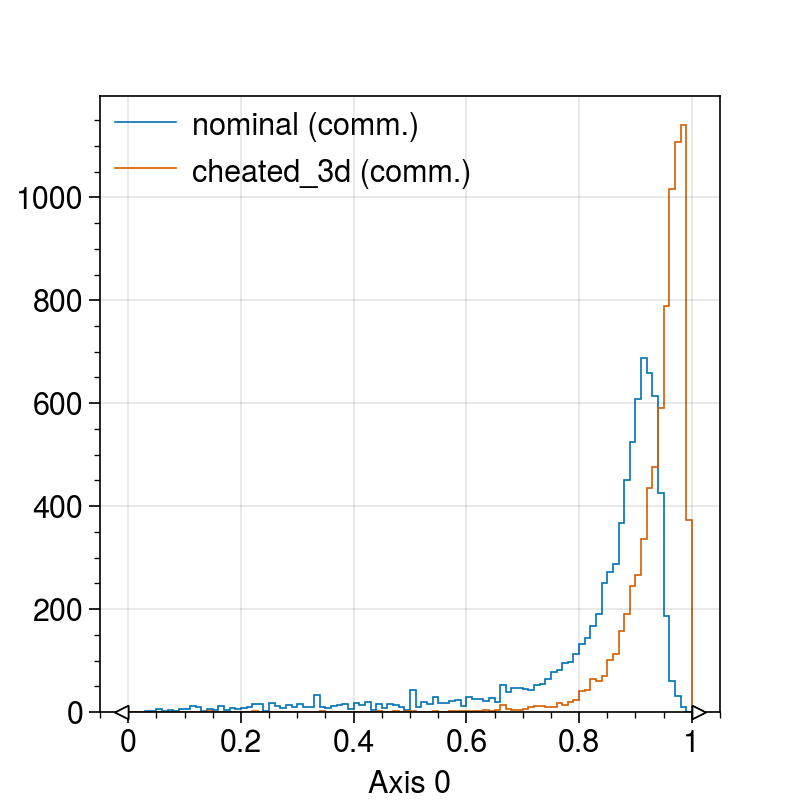

In [74]:
var='purity'
binning=hist.axis.Regular(100, 0, 1)
# plt.axvline(30, color='k')
(A,B), _ = muonsAna.get(['nominal', 'cheated_3d'], var, binning)
A0, _ = muonsAna.get('nominal', var, binning)
B0, _ = muonsAna.get('cheated_3d', var, binning)
hep.histplot(A, label='nominal (comm.)', yerr=False)
hep.histplot(B, label='cheated_3d (comm.)', yerr=False)
# hep.histplot(A0, label='nominal', yerr=False)
# hep.histplot(B0, label='cheated_3d', yerr=False)
plt.legend()
# plt.yscale('log')

In [75]:
print(f'{A[hist.loc(0):hist.loc(0.15)].counts().sum()/A.counts().sum():.3%}')

0.682%


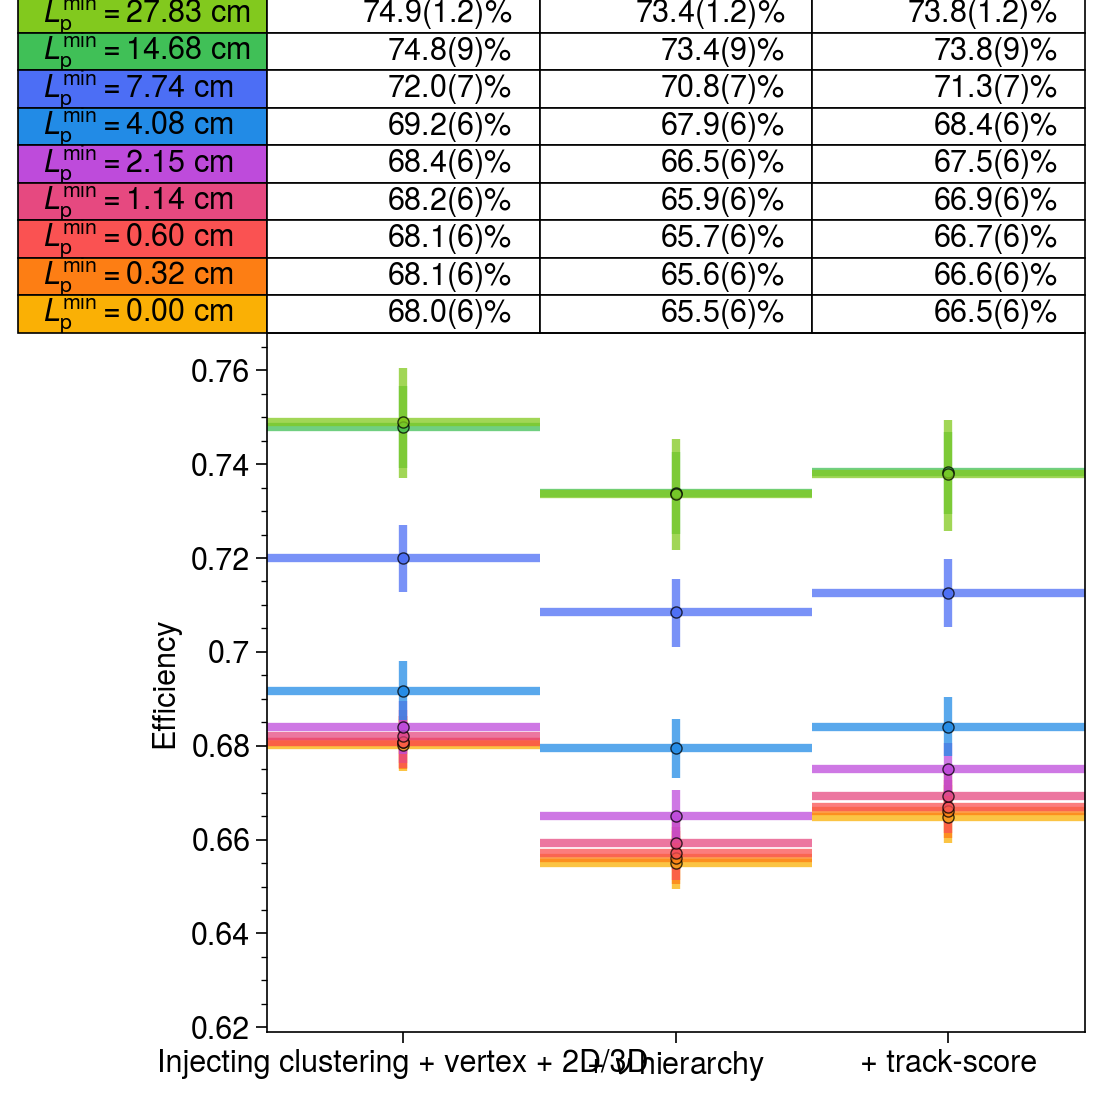

In [76]:
data = uproot.open('CCNp_anaProtonLength.root:efficiency_studies')

colllabels = [
        # 'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        # '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        'Injecting clustering + vertex + 2D/3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ]

fig, ax = plot.subplots(
    width=5.5, height=5.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    # ltitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xticks=[0, 1, 2, 3, 4], 
    xticklabels=colllabels,
    # xrotati,
    # , yscale='log'
)


cidx = 6

selections = {
    'L0': (0, f'yellow{cidx}'), 
    'L1': (0.31622777, f'orange{cidx}'), 
    'L2': (0.59948425, f'red{cidx}'), 
    'L3': (1.13646367, f'pink{cidx}'), 
    'L4': (2.15443469, f'grape{cidx}'), 
    'L5': (4.08423865, f'blue{cidx}'), 
    'L6': (7.74263683, f'indigo{cidx}'),
    'L7': (14.67799268, f'green{cidx}'),
    'L8': (27.82559402, f'lime{cidx}')
}
trees = [
    # 'cheated_2d',
    # 'cheated_2d_vtx',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_nu',
    'cheated_2d_vtx_3d_nu_mva',
    # 'nominal',
]

stringFormat = r'$L_\mathrm{{p}}^\mathrm{{min}} = {:.2f}$ cm'

analysisProtonLength = Analysis(data, hist.axis.Regular(1, 0.24, 2.4))

cell_text = []
rowLabel = []
rowColor = []

for i, stage in enumerate(trees):
    for cut in selections:
        
        efficiency, uncertainty = analysisProtonLength.efficiency(stage, cut)
        integrated_efficiency, _ = analysisProtonLength.efficiency(stage, cut)
        label, color = selections[cut]
        if i == 0: 
            rowLabel.append(stringFormat.format(label))
            rowColor.append(color)
        ax.errorbar(i, efficiency, yerr=uncertainty, xerr=0.5, color=color,
                    fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                    label=(stringFormat.format(label) if i==0 else None))
        cell_text.append(f'${ufloat(efficiency[0]*100, np.max(uncertainty)*100):uSL}$%')
        
table = ax.table(
    cellText=np.array(cell_text).reshape((len(trees),len(selections))).T[::-1], 
    loc='top', rowLabels=rowLabel[::-1], rowColours=rowColor[::-1], 
)

table.scale(1.,1.5)

# ax.axvline(4.5, color='k', lw=0.5)
# ax.axhline(0.95, color='k', lw=0.35, ls=':')
ax.format(
    # yscale=plot.scale.CutoffScale(.7, 2.15), 
    ymin=.619, ymax=.768
)
# ax.legend(ncols=3, loc='ul', order='C')

fig.savefig('plots_CCNp_test/CCNp_efficiencyAnalysisProtonLength.pdf', bbox_inches='tight')

In [77]:
analysisProtonLength = Analysis(data, hist.axis.Regular(18, 0.24, 2.4))

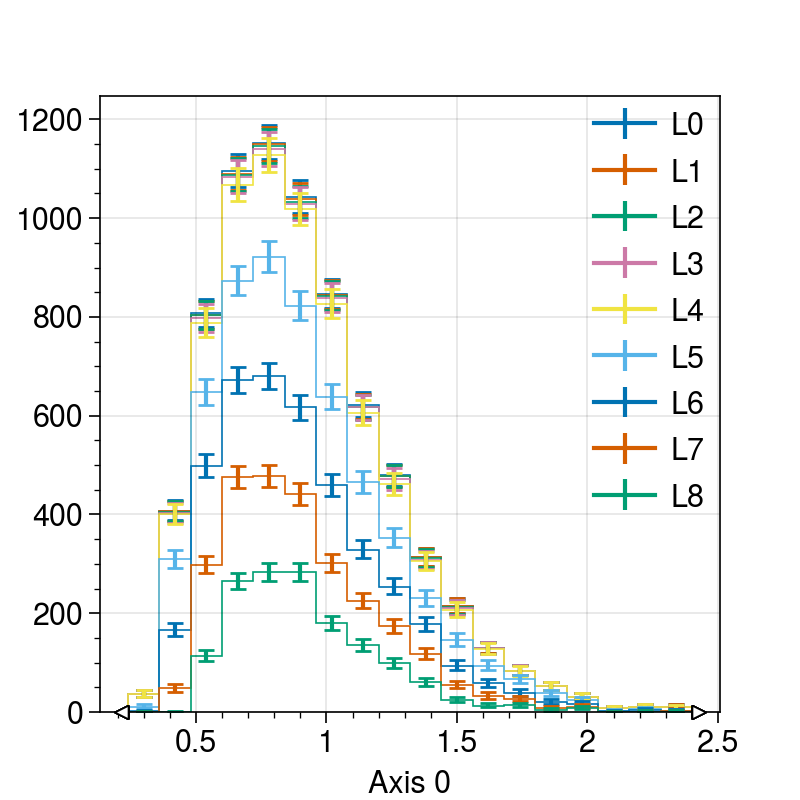

In [78]:
for s in selections: 
    _, _, a = analysisProtonLength.spectra('nominal', s)
    a.plot(label=s)
plt.legend()

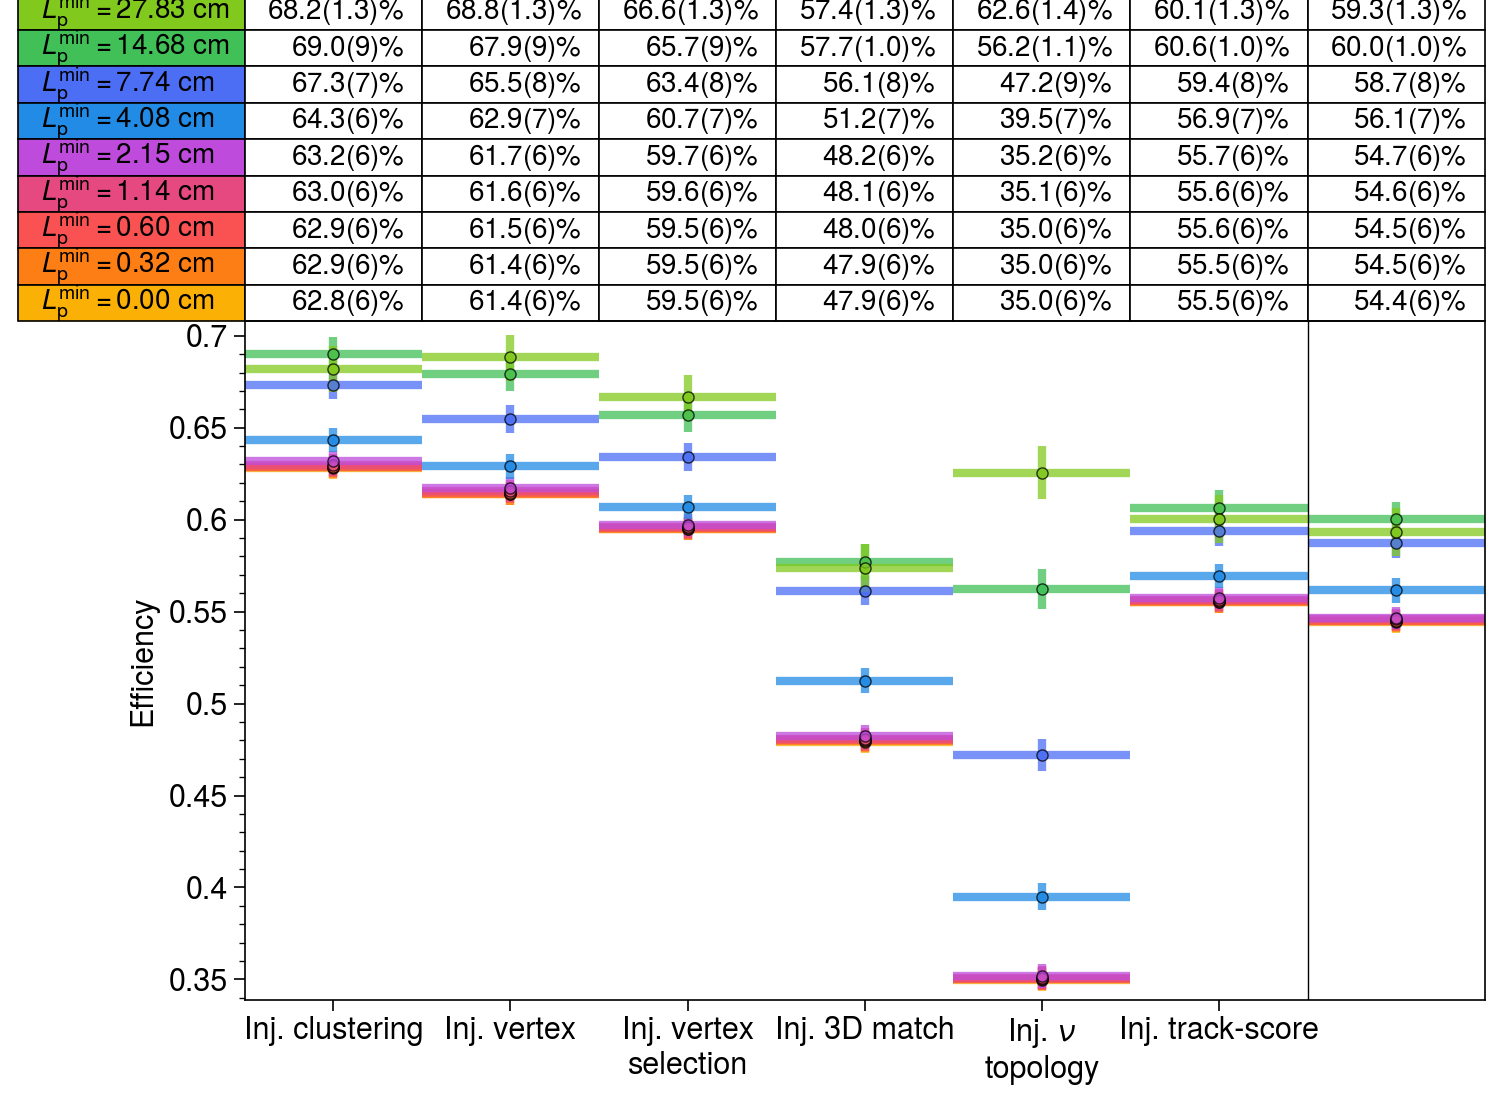

In [79]:
data = uproot.open('CCNp_anaProtonLength.root:efficiency_studies')

colllabels = [
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ]

fig, ax = plot.subplots(
    width=7.5, height=5.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    # ltitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection', 
    xticks=[0, 1, 2, 3, 4, 5, ], 
    xticklabels=[
        'Inj. clustering', 
        'Inj. vertex', 
        'Inj. vertex\nselection', 
        'Inj. 3D match',
        'Inj. $\\nu$\ntopology',
        'Inj. track-score', 
    ]
)


cidx = 6

selections = {
    'L0': (0, f'yellow{cidx}'), 
    'L1': (0.31622777, f'orange{cidx}'), 
    'L2': (0.59948425, f'red{cidx}'), 
    'L3': (1.13646367, f'pink{cidx}'), 
    'L4': (2.15443469, f'grape{cidx}'), 
    'L5': (4.08423865, f'blue{cidx}'), 
    'L6': (7.74263683, f'indigo{cidx}'),
    'L7': (14.67799268, f'green{cidx}'),
    'L8': (27.82559402, f'lime{cidx}')
}
trees = [
    'cheated_2d',
    'cheated_vtx',
    'cheated_vtxSelection',
    'cheated_3d',
    'cheated_nuH',
    'cheated_mva',
    'nominal',
]

stringFormat = r'$L_\mathrm{{p}}^\mathrm{{min}} = {:.2f}$ cm'

analysisProtonLength = Analysis(data, hist.axis.Regular(1, 0.24, 2.4))

cell_text = []
rowLabel = []
rowColor = []

for i, stage in enumerate(trees):
    for cut in selections:
        
        efficiency, uncertainty = analysisProtonLength.efficiency(stage, cut)
        integrated_efficiency, _ = analysisProtonLength.efficiency(stage, cut)
        label, color = selections[cut]
        if i == 0: 
            rowLabel.append(stringFormat.format(label))
            rowColor.append(color)
        ax.errorbar(i, efficiency, yerr=uncertainty, xerr=0.5, color=color,
                    fmt='o', markersize=4, mec='k', markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                    label=(stringFormat.format(label) if i==0 else None))
        cell_text.append(f'${ufloat(efficiency[0]*100, np.max(uncertainty)*100):uSL}$%')
        
table = ax.table(
    cellText=np.array(cell_text).reshape((len(trees),len(selections))).T[::-1], 
    loc='top', rowLabels=rowLabel[::-1], rowColours=rowColor[::-1], 
)

table.scale(1.,1.5)

ax.axvline(5.5, color='k', lw=0.5)
# ax.axhline(0.95, color='k', lw=0.35, ls=':')
ax.format(
    # yscale=plot.scale.CutoffScale(.7, 2.15), 
    ymin=.339, ymax=.708
)
# ax.legend(ncols=3, loc='ul', order='C')

fig.savefig('plots_CCNp_test/CCNp_efficiencyAnalysisProtonLengthSingle.pdf', bbox_inches='tight')

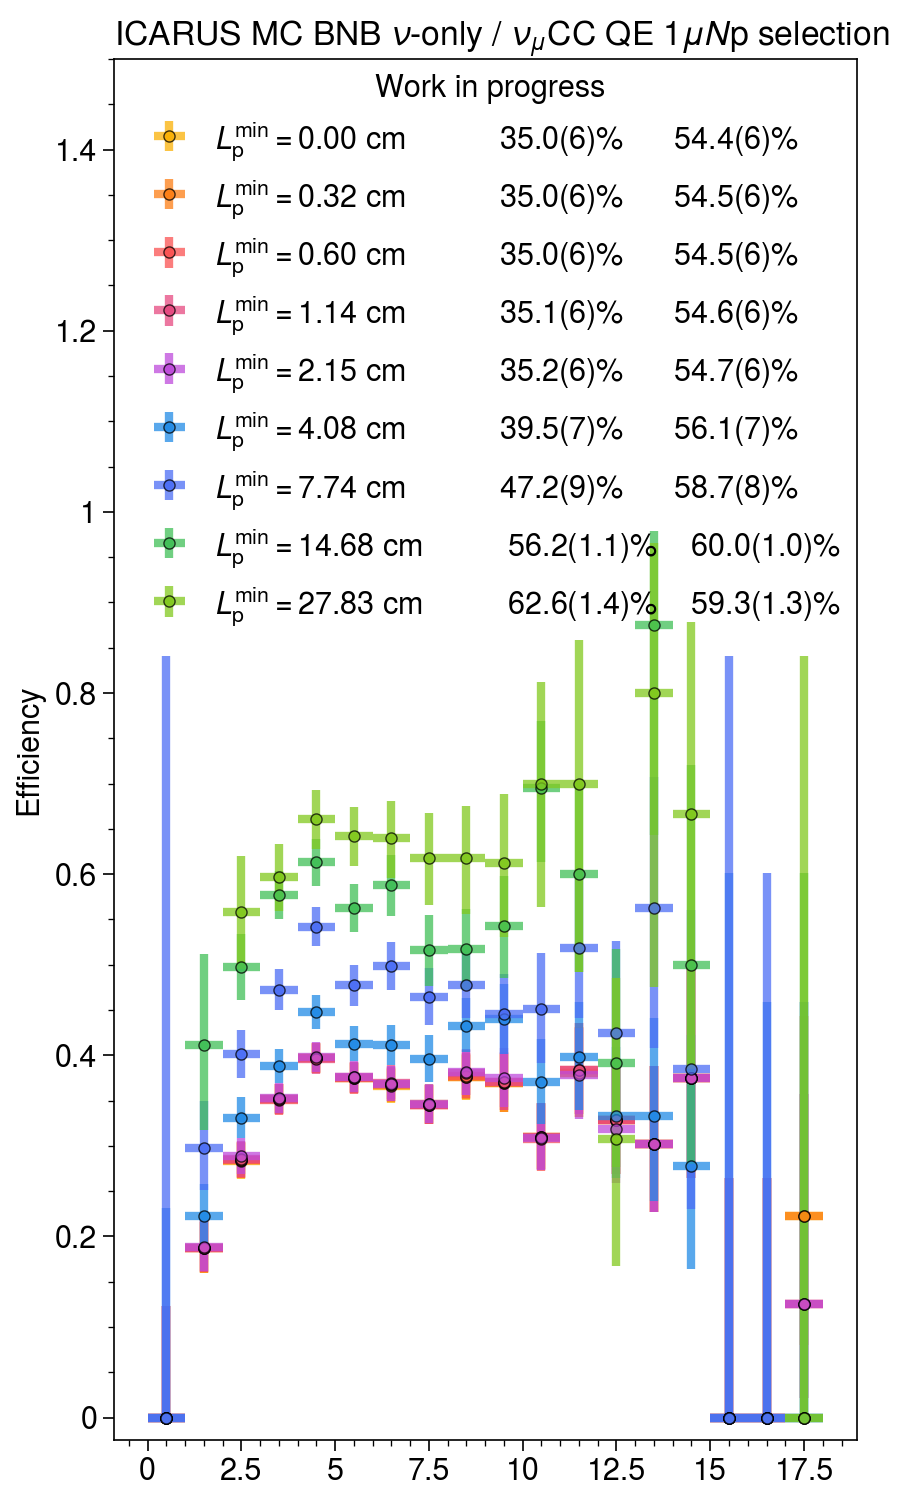

In [80]:
data = uproot.open('CCNp_anaProtonLength.root:efficiency_studies')

fig, ax = plot.subplots(
    width=4.5, height=7.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection',
    # rtitle='Work in progress'
)

cidx = 6

selections = {
    'L0': (0, f'yellow{cidx}'), 
    'L1': (0.31622777, f'orange{cidx}'), 
    'L2': (0.59948425, f'red{cidx}'), 
    'L3': (1.13646367, f'pink{cidx}'), 
    'L4': (2.15443469, f'grape{cidx}'), 
    'L5': (4.08423865, f'blue{cidx}'), 
    'L6': (7.74263683, f'indigo{cidx}'),
    'L7': (14.67799268, f'green{cidx}'),
    'L8': (27.82559402, f'lime{cidx}')
}

stringFormat = '$L_\\mathrm{{p}}^\\mathrm{{min}} = {:.2f}$ cm\t\t{}\t{}'

analysisProtonLength = Analysis(data, hist.axis.Regular(18, 0.24, 2.4))
analysisProtonLength_integrated = Analysis(data, hist.axis.Regular(1, 0.24, 2.4))

for cut in selections:
        
    efficiency, uncertainty = analysisProtonLength.efficiency('cheated_nuH', cut)
    integrated_efficiency, integrated_uncertainty = analysisProtonLength_integrated.efficiency('cheated_nuH', cut)

    nominal_efficiency, nominal_uncertainty = analysisProtonLength.efficiency('nominal', cut)
    nominal_integrated_efficiency, nominal_integrated_uncertainty = analysisProtonLength_integrated.efficiency('nominal', cut)
    
    label, color = selections[cut]
    hep.histplot(efficiency, xerr=True, yerr=uncertainty, color=color, histtype='errorbar', marker='o', markersize=4, mec='k', 
                 markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75,
                 label=stringFormat.format(
                     label, 
                     f'${ufloat(integrated_efficiency[0]*100, np.max(integrated_uncertainty)*100):uSL}$%',
                     f'${ufloat(nominal_integrated_efficiency[0]*100, np.max(nominal_integrated_uncertainty)*100):uSL}$%',
                 )
                )

    # hep.histplot(nominal_efficiency, yerr=False, color=color, histtype='fill', alpha=0.25, hatch='/////')
    ax.legend(ncols=1, label='Work in progress')
    ax.format(ymax=1.5)



(18,) (18,)


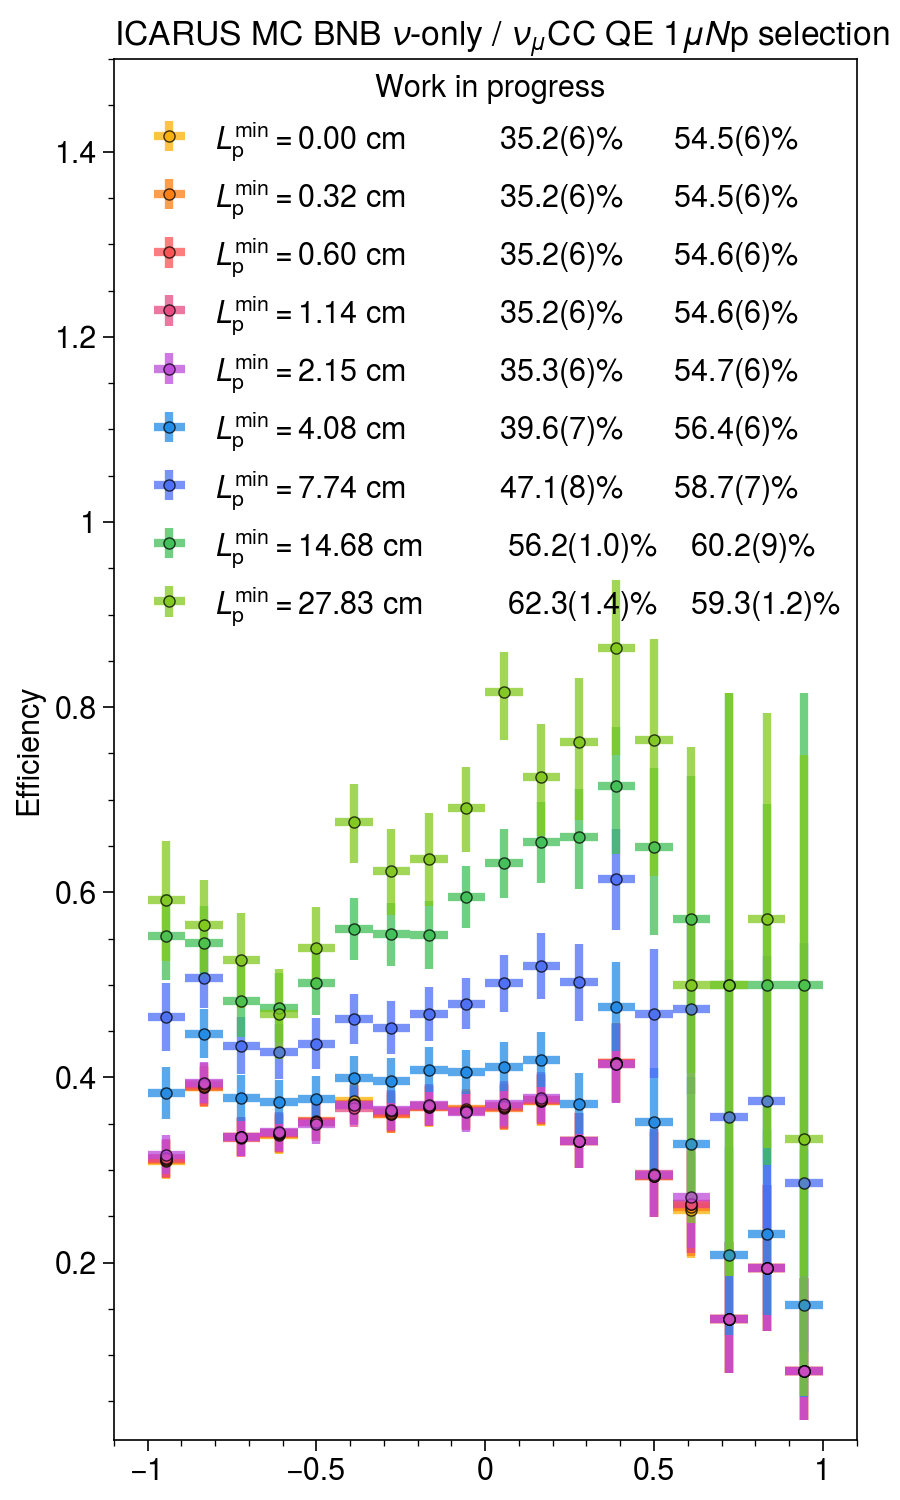

In [81]:
data = uproot.open('CCNp_anaMuonProtonAngle.root:efficiency_studies_trueVar')

class Analysis:
    def __init__(self, data, binning, tree_bases=['reco_true_{}', 'reco_{}', 'true_{}']):
        self.binning = binning
        self.data = data

        self.reco_true_base_string, self.reco_base_string, self.true_base_string = tree_bases

    def efficiency(self, tree_name: str, variable: str = 'true_E'):

        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.Evt, true.Evt, on='Evt')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.Evt.isin(common.Evt)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.Evt.isin(common.Evt)][variable].values)

        reco_true_values = reco_true_H.values()
        true_values = true_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            efficiency = reco_true_values/true_values
            efficiency_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, true_values, 'efficiency'
            )
        
        return efficiency, efficiency_uncertainty
    
    def purity(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.Evt, reco.Evt, on='Evt')
        
        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.Evt.isin(common.Evt)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.Evt.isin(common.Evt)][variable].values)

        reco_true_values = reco_true_H.values()
        reco_values = reco_H.values()
        
        with np.errstate(divide="ignore", invalid="ignore"):
            purity = reco_true_values/reco_values
            purity_uncertainty = hist.intervals.ratio_uncertainty(
                reco_true_values, reco_values, 'efficiency'
            )
        
        return purity, purity_uncertainty

    def spectra(self, tree_name: str, variable: str = 'true_E'):
        
        reco_true = self.data[self.reco_true_base_string.format(tree_name)].arrays(library='pd')
        reco = self.data[self.reco_base_string.format(tree_name)].arrays(library='pd')
        true = self.data[self.true_base_string.format(tree_name)].arrays(library='pd')

        common = pd.merge(reco_true.Evt, reco.Evt, on='Evt')
        common = pd.merge(common.Evt, true.Evt, on='Evt')

        reco_true_H = hist.Hist(self.binning).fill(reco_true[reco_true.Evt.isin(common.Evt)][variable].values)
        reco_H = hist.Hist(self.binning).fill(reco[reco.Evt.isin(common.Evt)][variable].values)
        true_H = hist.Hist(self.binning).fill(true[true.Evt.isin(common.Evt)][variable].values)

        return reco_true_H, reco_H, true_H


fig, ax = plot.subplots(
    width=4.5, height=7.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection',
    # rtitle='Work in progress'
)

cidx = 6

selections = {
    'L0': (0, f'yellow{cidx}'), 
    'L1': (0.31622777, f'orange{cidx}'), 
    'L2': (0.59948425, f'red{cidx}'), 
    'L3': (1.13646367, f'pink{cidx}'), 
    'L4': (2.15443469, f'grape{cidx}'), 
    'L5': (4.08423865, f'blue{cidx}'), 
    'L6': (7.74263683, f'indigo{cidx}'),
    'L7': (14.67799268, f'green{cidx}'),
    'L8': (27.82559402, f'lime{cidx}')
}

stringFormat = '$L_\\mathrm{{p}}^\\mathrm{{min}} = {:.2f}$ cm\t\t{}\t{}'

bins = hist.axis.Regular(18, -1, 1)

print(bins.centers.shape, efficiency.shape)


analysisProtonLength = Analysis(data, hist.axis.Regular(18, -1, 1))
analysisProtonLength_integrated = Analysis(data, hist.axis.Regular(1, -1, 1))

for cut in selections:
        
    efficiency, uncertainty = analysisProtonLength.efficiency('cheated_nuH', cut)
    integrated_efficiency, integrated_uncertainty = analysisProtonLength_integrated.efficiency('cheated_nuH', cut)

    nominal_efficiency, nominal_uncertainty = analysisProtonLength.efficiency('nominal', cut)
    nominal_integrated_efficiency, nominal_integrated_uncertainty = analysisProtonLength_integrated.efficiency('nominal', cut)
    
    label, color = selections[cut]
    ax.errorbar(bins.centers, efficiency, xerr=1/18, yerr=uncertainty, color=color, marker='o', markersize=4, mec='k', 
                 markeredgewidth=0.5, capsize=0, elinewidth=3, alpha=0.75, ls='',
                 label=stringFormat.format(
                     label, 
                     f'${ufloat(integrated_efficiency[0]*100, np.max(integrated_uncertainty)*100):uSL}$%',
                     f'${ufloat(nominal_integrated_efficiency[0]*100, np.max(nominal_integrated_uncertainty)*100):uSL}$%',
                 )
                )

    # hep.histplot(nominal_efficiency, yerr=False, color=color, histtype='fill', alpha=0.25, hatch='/////')
    ax.legend(ncols=1, label='Work in progress')
    ax.format(ymax=1.5)



In [82]:
bins

Regular(18, -1, 1)

nominal: 54.76%
cheated_slicing: 59.15%
nominal_cheatedPid: 71.31%
cheated_slicing_cheatedPid: 75.10%
cheated_2d: 63.13%
cheated_2d_vt: 68.19%
cheated_2d_vtx_3d: 68.51%
cheated_2d_vtx_3d_mva: 69.18%
cheated_2d_slicing: 64.02%
cheated_2d_vt_slicing: 69.31%
cheated_2d_vtx_3d_slicing: 69.57%
cheated_2d_vtx_3d_mva_slicing: 70.26%
cheated_2d_cheatedPid: 79.46%
cheated_2d_vt_cheatedPid: 86.48%
cheated_2d_vtx_3d_cheatedPid: 88.52%
cheated_2d_vtx_3d_mva_cheatedPid: 89.78%
cheated_2d_slicing_cheatedPid: 80.52%
cheated_2d_vt_slicing_cheatedPid: 87.78%
cheated_2d_vtx_3d_slicing_cheatedPid: 89.67%
cheated_2d_vtx_3d_mva_slicing_cheatedPid: 90.96%


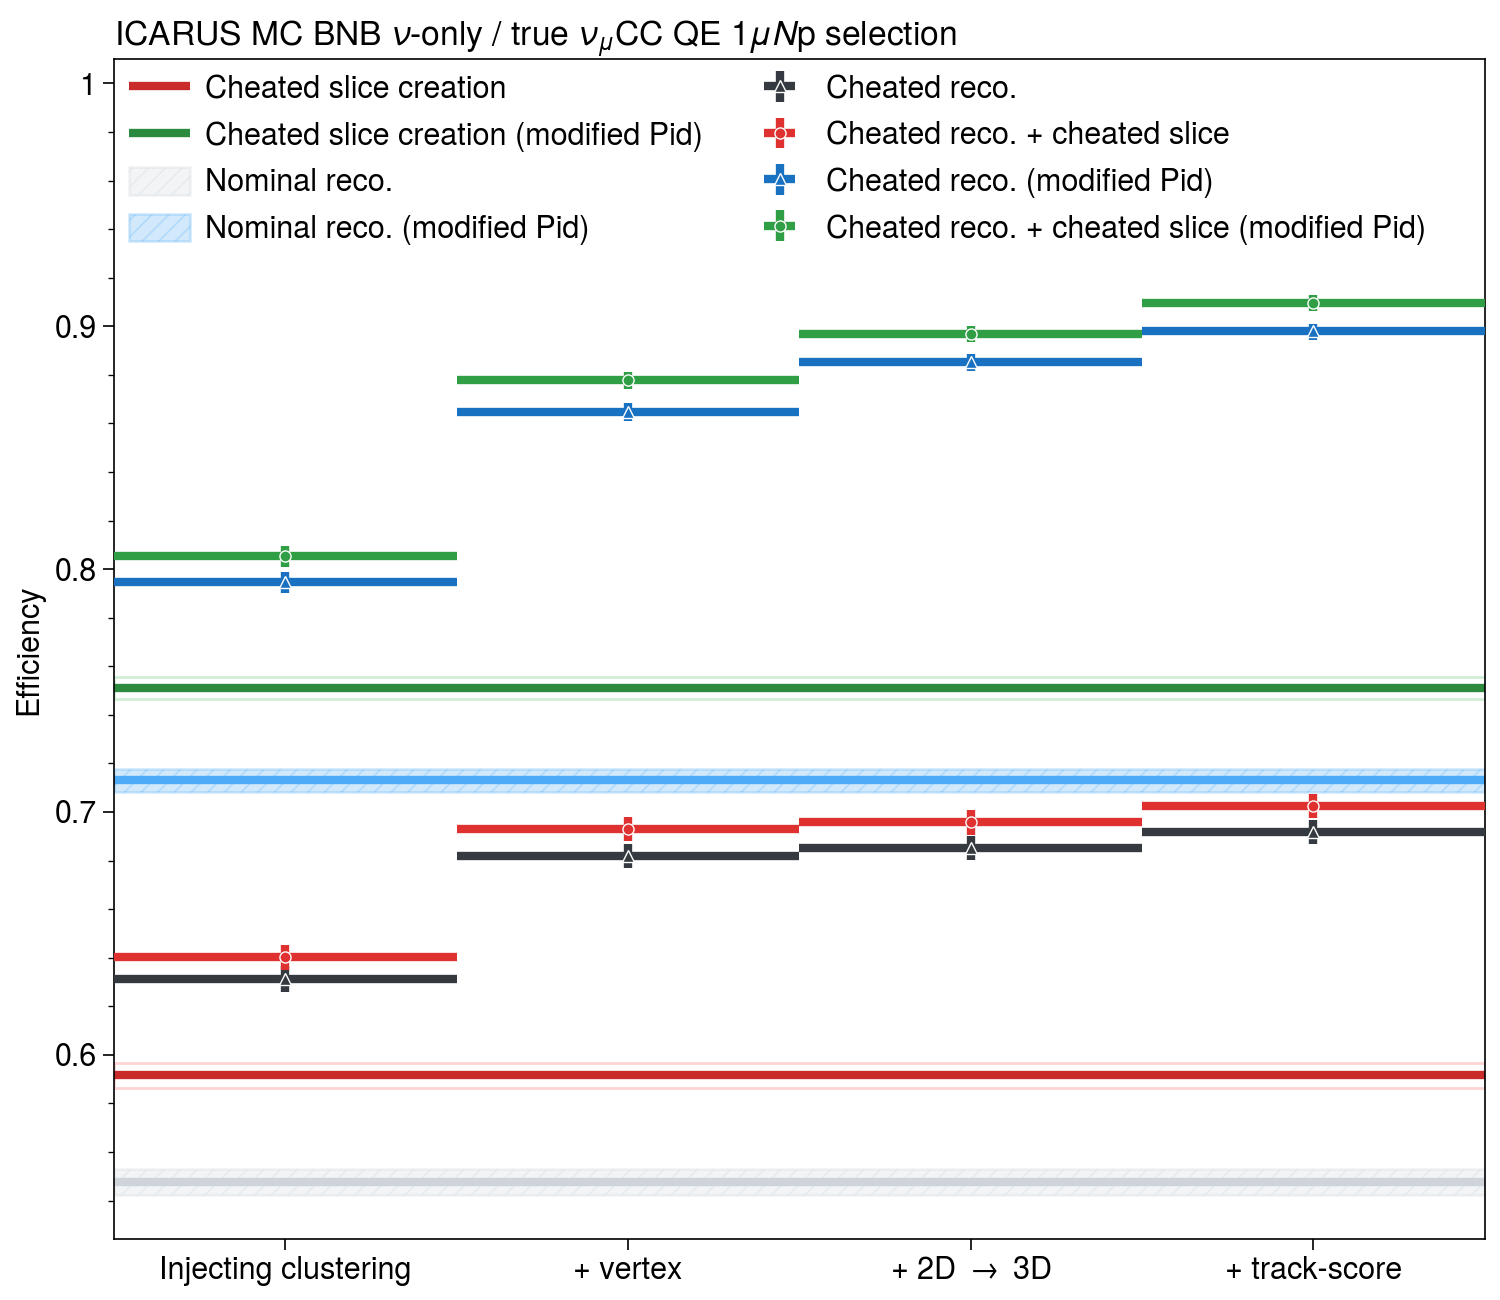

In [83]:
CCNp_data = uproot.open('CCNp_efficiencyNoNu_cheatingSlice_cheatingPid.root:efficiency_studies')
CCNp_analysis = Analysis(CCNp_data, hist.axis.Regular(1, 0.24, 2.4))

fig, ax = plot.subplots(
    width=7.5, height=6.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection',
    xticks=[0, 1, 2, 3], 
    xticklabels=[
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        # '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ],
    # xrotati,
    # urtitle=r'$1\mu N\mathrm{p}$ selection'
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'w', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2d',
    'cheated_2d_vt',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_mva',
]

trees_slicing = [
    'cheated_2d_slicing',
    'cheated_2d_vt_slicing',
    'cheated_2d_vtx_3d_slicing',
    'cheated_2d_vtx_3d_mva_slicing',
]


## NOMINAL RECO
efficiency, (low, high) = CCNp_analysis.efficiency('nominal', 'E')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='gray4', ec='gray4', alpha=0.25, linewidth=1, label='Nominal reco.', zorder=-99)
ax[0].axhline(efficiency, lw=3, c='gray4')
print(f'{'nominal'}: {efficiency[0]:.2%}')

efficiency, (low, high) = CCNp_analysis.efficiency('cheated_slicing', 'E')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], fill=False, color='red6', ec='red6', alpha=0.25, linewidth=1, zorder=-99)
ax[0].axhline(efficiency, lw=3, c='red9', label='Cheated slice creation')
print(f'{'cheated_slicing'}: {efficiency[0]:.2%}')

## Cheated PID
efficiency, (low, high) = CCNp_analysis.efficiency('nominal_cheatedPid', 'E')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='blue4', ec='blue4', alpha=0.25, linewidth=1, label='Nominal reco. (modified Pid)', zorder=-99)
ax[0].axhline(efficiency, lw=3, c='blue4')
print(f'{'nominal_cheatedPid'}: {efficiency[0]:.2%}')

efficiency, (low, high) = CCNp_analysis.efficiency('cheated_slicing_cheatedPid', 'E')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], fill=False, color='green6', ec='green6', alpha=0.25, linewidth=1, zorder=-99)
ax[0].axhline(efficiency, lw=3, c='green9', label='Cheated slice creation (modified Pid)')
print(f'{'cheated_slicing_cheatedPid'}: {efficiency[0]:.2%}')

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = CCNp_analysis.efficiency(tree, 'E')
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='gray8', fmt='^', label=('Cheated reco.' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')

for i, tree in enumerate(trees_slicing):
    efficiency, uncertainty = CCNp_analysis.efficiency(tree, 'E')
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='red8', fmt='o', label=('Cheated reco. + cheated slice' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')

## LADDER cheated pid
for i, tree in enumerate(trees):
    tree = tree + '_cheatedPid'
    efficiency, uncertainty = CCNp_analysis.efficiency(tree, 'E')
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='blue8', fmt='^', label=('Cheated reco. (modified Pid)' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')

for i, tree in enumerate(trees_slicing):
    tree = tree + '_cheatedPid'
    efficiency, uncertainty = CCNp_analysis.efficiency(tree, 'E')
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='green8', fmt='o', label=('Cheated reco. + cheated slice (modified Pid)' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')

# ax[1].format(urtitle='', ultitle=r'$1\mu1p$ selection')
[axi.legend(loc='ul', ncols=2, order='F') for axi in ax]
# [axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

ax.format(ylim=(0.524, 1.01))


fig.savefig('plots_CCNp_test/CCNp_efficiencyNoNu_cheatingSlice_cheatingPid.pdf', bbox_inches='tight')

nominal: 54.76%
nominal_cheatedPid: 71.31%
cheated_2d: 63.13%
cheated_2d_vt: 68.19%
cheated_2d_vtx_3d: 68.51%
cheated_2d_vtx_3d_mva: 69.18%
cheated_2d_cheatedPid: 79.46%
cheated_2d_vt_cheatedPid: 86.48%
cheated_2d_vtx_3d_cheatedPid: 88.52%
cheated_2d_vtx_3d_mva_cheatedPid: 89.78%


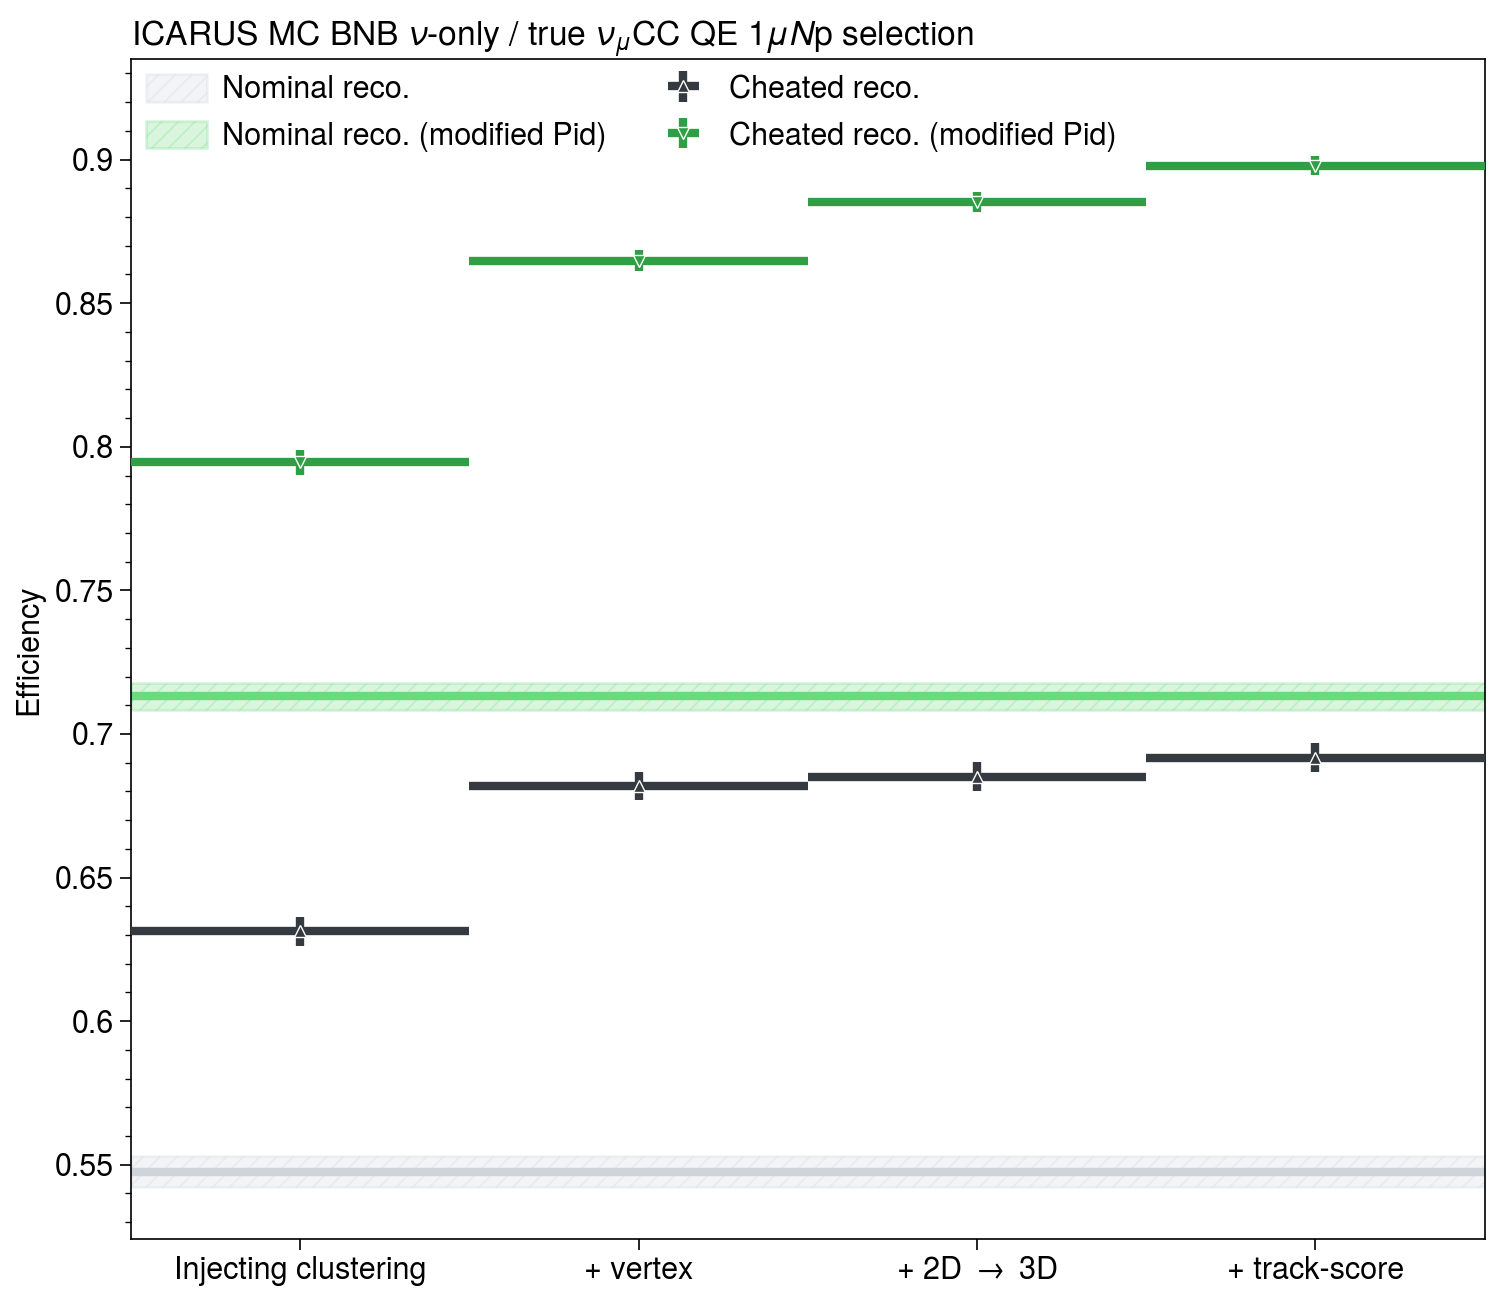

In [90]:
CCNp_data = uproot.open('CCNp_efficiencyNoNu_cheatingSlice_cheatingPid.root:efficiency_studies')
CCNp_analysis = Analysis(CCNp_data, hist.axis.Regular(1, 0.24, 2.4))

fig, ax = plot.subplots(
    width=7.5, height=6.5, ncols=1, nrows=1, ylabel=f'Efficiency',
    titlecolor='k', share=False, grid=False, # sharey='labs',
    ltitle=r'ICARUS MC BNB $\nu$-only / true $\nu_\mu$CC QE $1\mu N\mathrm{p}$ selection',
    xticks=[0, 1, 2, 3], 
    xticklabels=[
        'Injecting clustering',# 'Cheated $2\\mathrm{D}$', 
        '+ vertex',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex}$', 
        '+ 2D $\\to$ 3D',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D}$', 
        # '+ $\\nu$ hierarchy',# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy}$', 
        '+ track-score'# 'Cheated $2\\mathrm{D} + \\mathrm{vertex} + 3\\mathrm{D} + $\n$ + \\nu\\text{-hierarchy} + \\mathrm{MVA}$', 
    ],
    # xrotati,
    # urtitle=r'$1\mu N\mathrm{p}$ selection'
    # , yscale='log'
)

cheated_dict = {
    'xerr': 0.5, 
    'markersize': 4, 
    'mec': 'w', 
    'markeredgewidth': 0.5, 
    'capsize': 0, 
    'elinewidth': 3
}

trees = [
    'cheated_2d',
    'cheated_2d_vt',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_mva',
]

reconstruction_efficiency = {}

## NOMINAL RECO
efficiency, (low, high) = CCNp_analysis.efficiency('nominal', 'E')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='gray4', ec='gray4', alpha=0.25, linewidth=1, label='Nominal reco.', zorder=-99)
ax[0].axhline(efficiency, lw=3, c='gray4')
print(f'{'nominal'}: {efficiency[0]:.2%}')

reconstruction_efficiency['nominal'] = (efficiency[0], np.max([low, high]))

## Cheated PID
efficiency, (low, high) = CCNp_analysis.efficiency('nominal_cheatedPid', 'E')
ax[0].axhspan(ymin=(efficiency-low)[0], ymax=(efficiency+high)[0], hatch='////', fill=True, color='green4', ec='green4', alpha=0.25, linewidth=1, label='Nominal reco. (modified Pid)', zorder=-99)
ax[0].axhline(efficiency, lw=3, c='green4')
print(f'{'nominal_cheatedPid'}: {efficiency[0]:.2%}')

reconstruction_efficiency['nominal_cheatedPid'] = (efficiency[0], np.max([low, high]))

## LADDER 
for i, tree in enumerate(trees):
    efficiency, uncertainty = CCNp_analysis.efficiency(tree, 'E')
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='gray8', fmt='^', label=('Cheated reco.' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')
    reconstruction_efficiency[tree] = (efficiency[0], np.max(uncertainty))

## LADDER cheated pid
for i, tree in enumerate(trees):
    tree = tree + '_cheatedPid'
    efficiency, uncertainty = CCNp_analysis.efficiency(tree, 'E')
    ax[0].errorbar(i, efficiency, yerr=uncertainty, **cheated_dict, color='green8', fmt='v', label=('Cheated reco. (modified Pid)' if i==0 else None), zorder=99)
    print(f'{tree}: {efficiency[0]:.2%}')
    reconstruction_efficiency[tree] = (efficiency[0], np.max(uncertainty))

# ax[1].format(urtitle='', ultitle=r'$1\mu1p$ selection')
[axi.legend(loc='ul', ncols=2, order='F') for axi in ax]
# [axi.set_title('Preliminary', color='k', loc='left', weight='bold') for axi in ax]

ax.format(ylim=(0.524, .935))


fig.savefig('plots_CCNp_test/CCNp_efficiencyNoNu_cheatingPid.pdf', bbox_inches='tight')

In [118]:
trees = [
    'nominal'
    'cheated_2d',
    'cheated_2d_vt',
    'cheated_2d_vtx_3d',
    'cheated_2d_vtx_3d_mva',
]

# first numerator, second denominator (pid efficiency is inverted
stageToConfigs = {
    '2d': ('cheated_2d', 'nominal'),
    'vtx': ('cheated_2d_vt', 'cheated_2d'),
    '3d': ('cheated_2d_vtx_3d', 'cheated_2d_vt'),
    'mva': ('cheated_2d_vtx_3d_mva', 'cheated_2d_vtx_3d'),
}

stages_efficiency = {}

for stage in stageToConfigs:
    A, B = stageToConfigs[stage]
    effA, effErrA = reconstruction_efficiency[A]
    effAModifiedPid, effErrAModifiedPid = reconstruction_efficiency[f'{A}_cheatedPid']

    effB, effErrB = reconstruction_efficiency[B]
    effBModifiedPid, effErrBModifiedPid = reconstruction_efficiency[f'{B}_cheatedPid']

    print('\n__________')
    print(f'Computing stage {stage}\n----------')
    print(f'Double checks')
    print(f'To get {stage} it is eff_selection({B})/eff_selection({A}) * eff_pid({A})/eff_pid({B})')
    print(f'To get eff_pid({A}) it is eff_selection({A})/eff_selection({A}_cheatedPid)')
    print(f'To get eff_pid({B}) it is eff_selection({B})/eff_selection({B}_cheatedPid)')
    print(f'   where')
    print(f'      {B} = {ufloat(effB, effErrB)*100:uS}%')
    print(f'      {A} = {ufloat(effA, effErrA)*100:uS}%')
    print(f'   where')
    print(f'      {B}_cheatedPid = {ufloat(effBModifiedPid, effErrBModifiedPid)*100:uS}%')
    print(f'      {A}_cheatedPid = {ufloat(effAModifiedPid, effErrAModifiedPid)*100:uS}%')

    effPidA = effA/effAModifiedPid
    effErrPidA = np.sqrt((effErrA / effA)**2 + (effErrAModifiedPid / effAModifiedPid)**2) * effPidA
    
    effPidB = effB/effBModifiedPid
    effErrPidB = np.sqrt((effErrB / effB)**2 + (effErrBModifiedPid / effBModifiedPid)**2) * effPidB

    print('__________')
    print(f'eff_pid({A}) = {ufloat(effPidA, effErrPidA)*100:uS}%')
    print(f'eff_pid({B}) = {ufloat(effPidB, effErrPidB)*100:uS}%')

    effStage = ( effB / effA ) * ( effPidA / effPidB )
    effErrStage = np.sqrt((effErrA / effA)**2 + (effErrB / effB)**2 + (effErrPidA / effPidA)**2 + (effErrPidB / effPidB)**2) * effStage

    print('__________')
    print(f'eff({stage}) = {ufloat(effStage, effErrStage)*100:uS}%')
    


__________
Computing stage 2d
----------
Double checks
To get 2d it is eff_selection(nominal)/eff_selection(cheated_2d) * eff_pid(cheated_2d)/eff_pid(nominal)
To get eff_pid(cheated_2d) it is eff_selection(cheated_2d)/eff_selection(cheated_2d_cheatedPid)
To get eff_pid(nominal) it is eff_selection(nominal)/eff_selection(nominal_cheatedPid)
   where
      nominal = 54.8(5)%
      cheated_2d = 63.1(5)%
   where
      nominal_cheatedPid = 71.3(5)%
      cheated_2d_cheatedPid = 79.5(4)%
__________
eff_pid(cheated_2d) = 79.4(8)%
eff_pid(nominal) = 76.8(9)%
__________
eff(2d) = 89.7(1.8)%

__________
Computing stage vtx
----------
Double checks
To get vtx it is eff_selection(cheated_2d)/eff_selection(cheated_2d_vt) * eff_pid(cheated_2d_vt)/eff_pid(cheated_2d)
To get eff_pid(cheated_2d_vt) it is eff_selection(cheated_2d_vt)/eff_selection(cheated_2d_vt_cheatedPid)
To get eff_pid(cheated_2d) it is eff_selection(cheated_2d)/eff_selection(cheated_2d_cheatedPid)
   where
      cheated_2d = 63.1(5